# OneK1K aging signature analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import glob
from tqdm import tqdm
import scipy
import pertpy
import yaml

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

import process as process
import plot as plot
# from DE_analysis_utils import *

In [4]:
with open('../../metadata/figure_palettes.yaml', 'r') as f:
    palettes = yaml.safe_load(f)

In [5]:
datadir = '/mnt/oak/users/emma/data/GWT/OneK1K_analysis/'
figdir = 'figures/'
resultsdir = 'results/'
h5ad_file = '/mnt/oak/users/emma/data/cxg_datasets/Yazar2022.h5ad'


### Preprocess data by celltype

In [ ]:

ct_classes = {
    "CD4T":['central memory CD4-positive, alpha-beta T cell', 'naive thymus-derived CD4-positive, alpha-beta T cell', 'effector memory CD4-positive, alpha-beta T cell'],
    "CD8T":['effector memory CD8-positive, alpha-beta T cell', 'naive thymus-derived CD8-positive, alpha-beta T cell', 'central memory CD8-positive, alpha-beta T cell'],
    "B":['naive B cell', 'memory B cell'],
    'NK':['natural killer cell','CD16-negative, CD56-bright natural killer cell, human']
}

for ct in ct_classes.keys():
    keep_cell_types = ct_classes[ct]
    output_file = datadir + f"Yazar2022_{ct}_processed.h5ad"
    print(output_file)
    adata_1k1k = anndata.experimental.read_lazy(h5ad_file)
    adata = anndata.AnnData(
                obs=adata_1k1k.obs.to_dataframe(),
                var=adata_1k1k.var.to_dataframe(),
                X = adata_1k1k.X
            )
    adata = adata[adata.obs['cell_type'].isin(keep_cell_types)].to_memory()

    # Normalize
    scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
    adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

    # QC
    gene_name_col = 'feature_name'
    counts_col = 'nCount_RNA'
    adata.var["mt"] = adata.var[gene_name_col].str.startswith("MT-")
    adata.var["ribo"] = adata.var[gene_name_col].str.startswith(("RPS", "RPL"))
    adata.var["hb"] = adata.var[gene_name_col].str.contains("^HB[^(P)]")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)
    adata = process.filter_outliers(adata)

    sc.pp.highly_variable_genes(adata, layer="log1p_norm", n_top_genes=10000)
    adata.write(output_file, compression="gzip")

In [14]:
# lymph_count_lof = pd.read_table('/mnt/oak/users/mineto/workstation/250717_TcellPerturb/input/burden/Backman_LymphocyteCount_fullFeatures.per_gene_estimates.tsv', index_col=0)
# # Find genes present in both datasets
# common_regs = lymph_count_lof.index.intersection(adata_de_obs['target_contrast'].unique())
# # Get target names for common regulators
# target_names_map = adata_de_obs.loc[adata_de_obs['target_contrast'].isin(common_regs), ['target_contrast', 'target_contrast_gene_name']].drop_duplicates().set_index('target_contrast')['target_contrast_gene_name']

# # Add target name column to lymph_count_lof for common regulators
# lymph_count_lof_subset = lymph_count_lof.loc[common_regs].copy()
# lymph_count_lof_subset['target_name'] = target_names_map
# # Sort by post_mean and get ranks
# ranked_data = lymph_count_lof_subset.sort_values('post_mean').reset_index()
# ranked_data['rank'] = range(len(ranked_data))

# # Plot post_mean vs rank
# plt.figure(figsize=(10,6))
# plt.scatter(ranked_data['rank'], ranked_data['post_mean'], alpha=0.5, s=20)

# # Annotate top 5 and bottom 5
# from adjustText import adjust_text

# texts = []
# for i in range(10):
#     # Bottom 5
#     texts.append(plt.text(ranked_data['rank'].iloc[i], 
#                          ranked_data['post_mean'].iloc[i],
#                          ranked_data['target_name'].iloc[i]))
    
#     # Top 5
#     texts.append(plt.text(ranked_data['rank'].iloc[-(i+1)], 
#                          ranked_data['post_mean'].iloc[-(i+1)],
#                          ranked_data['target_name'].iloc[-(i+1)]))

# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

# plt.xlabel('Rank')
# plt.ylabel('Post Mean')
# plt.title('Gene Effect Size Rankings')
# plt.show()

### Read outputs from DE analysis

Run with `1k1k_analysis.py`

In [6]:
# get features used on perturb-seq dataset
adata_de_var = sc.read_h5ad(f'/mnt/oak/users/emma/data/GWT/CD4i_final//DE_results_all_confounders/CD4i_final.merged_DE_results.h5ad').var
adata_de_obs = sc.read_h5ad(f'/mnt/oak/users/emma/data/GWT/CD4i_final//DE_results_all_confounders/CD4i_final.merged_DE_results.h5ad').obs

NaNs encountered, dropping rows with NaNs


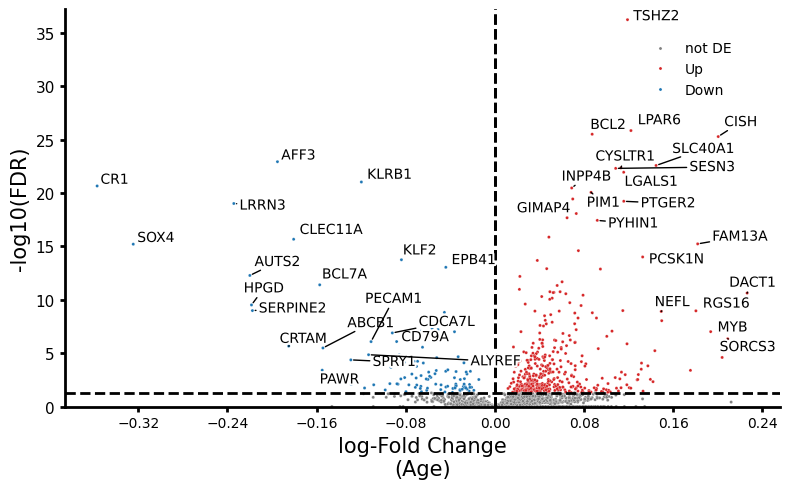

<Figure size 800x2000 with 0 Axes>

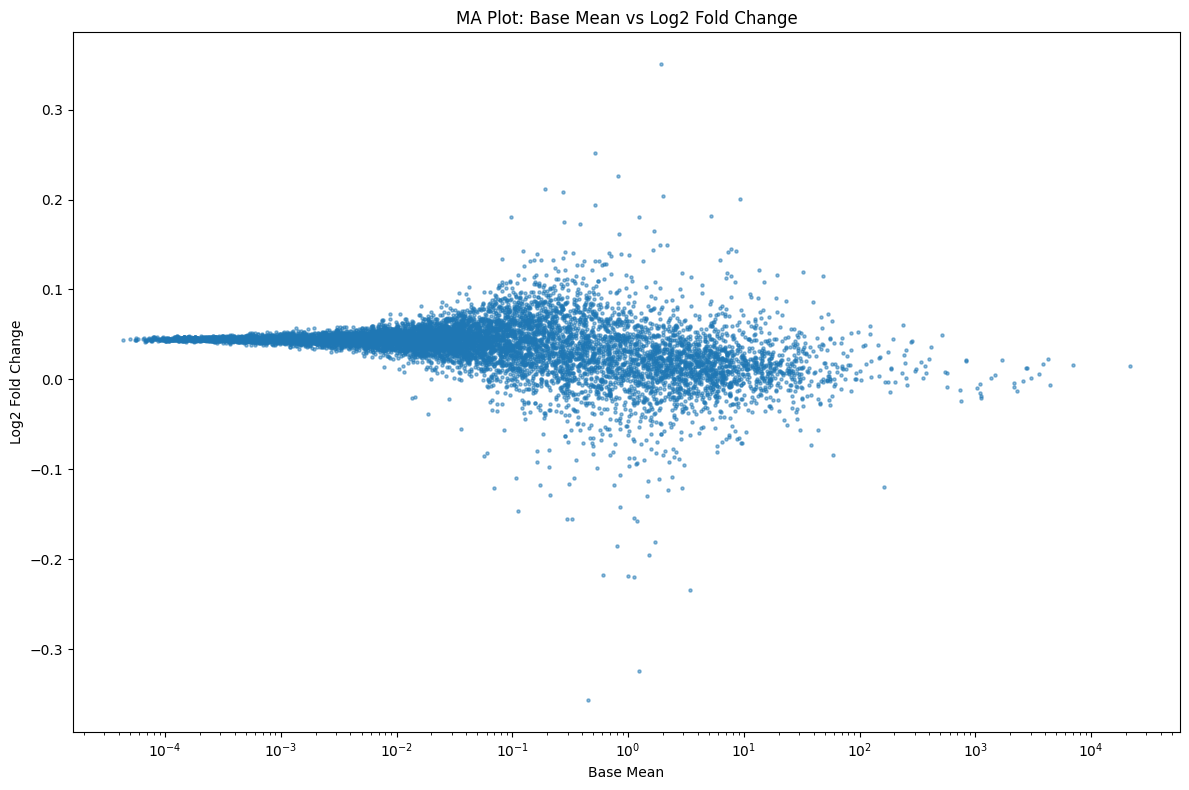

In [7]:
ct = 'CD4T'
pbulk_adata = sc.read_h5ad(datadir + f"Yazar2022_{ct}_processed.pbulk.h5ad")
pbulk_adata.var_names.isin(adata_de_var.index).sum()

res_df = pd.read_csv(f'results/DE_age_cat_{ct}_train.csv')
res_df = res_df.rename({'log2FoldChange':'log_fc', 'padj':'adj_p_value', 'ensembl_id':'variable'}, axis=1)
res_df['gene_name'] = pbulk_adata.var.loc[res_df.variable]['feature_name'].values
res_df['perturbseq_gene'] = res_df['variable'].isin(adata_de_var.index)
res_df['contrast'] = 'age'
res_df['zscore'] = res_df['log_fc']/res_df['lfcSE']
res_df['adj_p_value'] = res_df['adj_p_value'].fillna(1)

onek1k_design = f"~ male + age_cat"
model = pertpy.tl.PyDESeq2(pbulk_adata, design=onek1k_design)

fig = model.plot_volcano(
    res_df[res_df['perturbseq_gene']], 
    log2fc_thresh=0, 
    return_fig=True, 
    to_label = 20,
    symbol_col='gene_name',
    figsize=(8, 5),  # Increased figure size
    s=5,
    legend_pos = (0.95,0.95),
    y_label = '-log10(FDR)', x_label='log-Fold Change\n(Age)'
    )
fig.tight_layout()  
fig.show()  

plt.figure(figsize=(8,20))
fig = plt.figure(figsize=(12, 8))
plt.scatter(res_df['baseMean'], res_df['log_fc'], alpha=0.5, s=5)
plt.xscale('log')
plt.xlabel('Base Mean')
plt.ylabel('Log2 Fold Change') 
plt.title('MA Plot: Base Mean vs Log2 Fold Change')
fig.tight_layout()
plt.show()

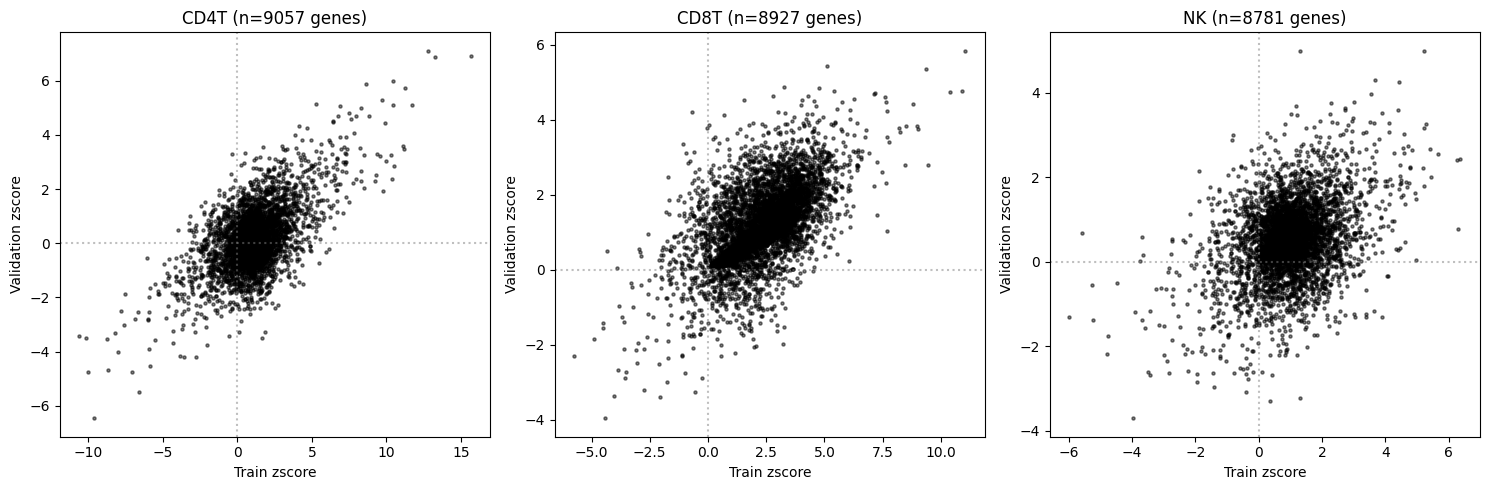

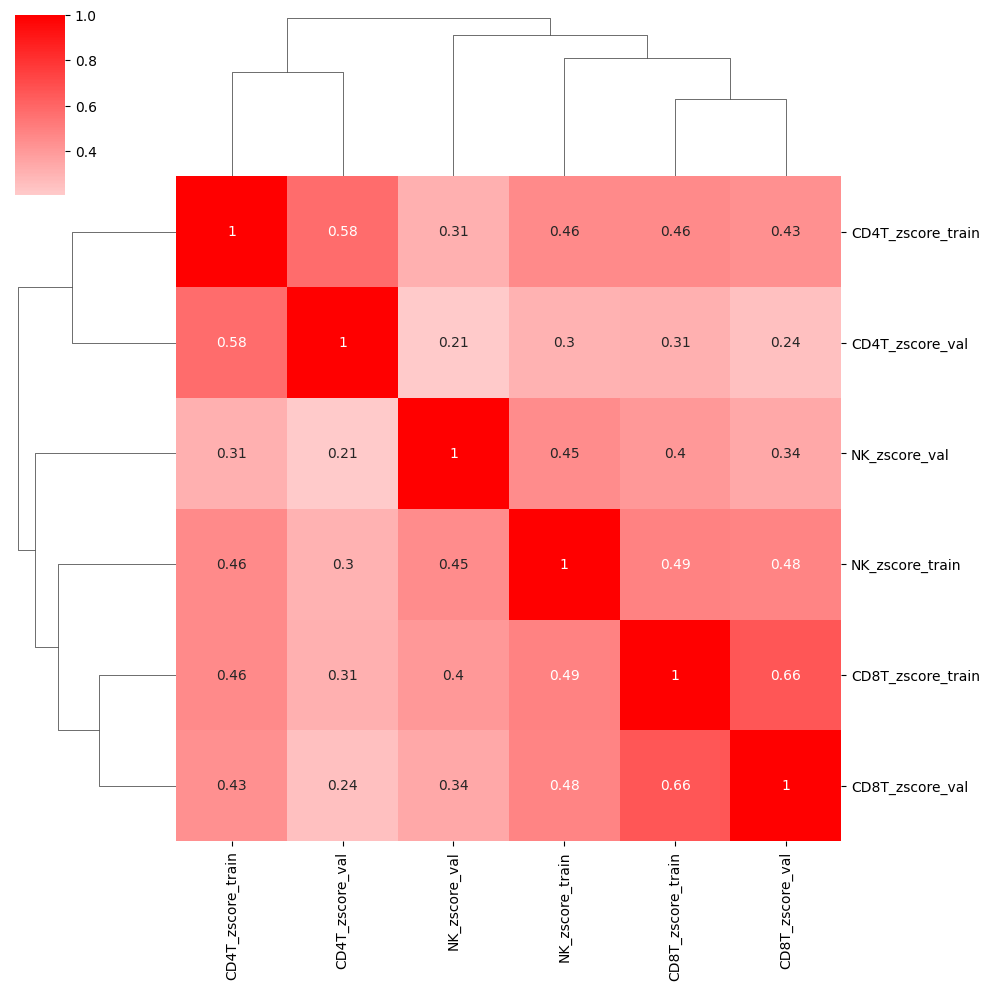

In [7]:
def get_reliability(x, sigma):
    sigma2_obs = np.var(x, ddof=1)  # Observed variance across features
    sigma2_sem = np.mean(sigma**2)   # Average squared standard error
    sigma2_true = sigma2_obs - sigma2_sem  # Estimated true signal variance
    reliability = sigma2_true / (sigma2_true + sigma2_sem)
    return(reliability)

def get_max_correlation(x_a, sigma_a, x_b, sigma_b):
    """Calculate maximum possible correlation"""
    rel_a = get_reliability(x_a, sigma_a)
    rel_b = get_reliability(x_b, sigma_b)
    return np.sqrt(rel_a * rel_b)

def get_lfc_correlation(x_a, sigma_a, x_b, sigma_b):
    """Calculate maximum possible correlation"""
    corr = x_a.corr(x_b)
    corr_ceil = get_max_correlation(x_a, sigma_a, x_b, sigma_b)
    return corr, corr_ceil

# Define cell type classes
ct_classes = ['CD4T', 'CD8T', 'NK']

# Read pbulk data
pbulk_adata = sc.read_h5ad('pbulked.h5ad')

# Dictionary to store results for each cell type
train_results = {}
val_results = {}

# Load results for each cell type
for ct in ct_classes:
    pbulk_adata = sc.read_h5ad(datadir + f"Yazar2022_{ct}_processed.pbulk.h5ad")
    pbulk_adata.var_names.isin(adata_de_var.index).sum()
    # Read and process training data
    train_df = pd.read_csv(f'results/DE_age_cat_{ct}_train.csv')
    train_df = train_df[train_df['baseMean'] > 0]
    train_df = train_df.rename({'log2FoldChange':'log_fc', 'padj':'adj_p_value', 'ensembl_id':'variable'}, axis=1)
    train_df['gene_name'] = pbulk_adata.var.loc[train_df.variable]['feature_name'].values
    train_df['perturbseq_gene'] = train_df['variable'].isin(adata_de_var.index)
    train_df['zscore'] = train_df['log_fc']/train_df['lfcSE']
    train_df['adj_p_value'] = train_df['adj_p_value'].fillna(1)
    train_results[ct] = train_df

    # Read and process validation data
    val_df = pd.read_csv(f'results/DE_age_cat_{ct}_validation.csv')
    val_df = val_df[val_df['baseMean'] > 0]
    val_df = val_df.rename({'log2FoldChange':'log_fc', 'padj':'adj_p_value', 'ensembl_id':'variable'}, axis=1)
    val_df['gene_name'] = pbulk_adata.var.loc[val_df.variable]['feature_name'].values
    val_df['perturbseq_gene'] = val_df['variable'].isin(adata_de_var.index)
    val_df['zscore'] = val_df['log_fc']/val_df['lfcSE']
    val_df['adj_p_value'] = val_df['adj_p_value'].fillna(1)
    val_results[ct] = val_df

# Plot train vs validation zscores for common genes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ct in enumerate(ct_classes):
    # Get genes present in both train and validation sets
    common_genes = set(train_results[ct]['variable']) & set(val_results[ct]['variable'])
    
    # Filter for common genes
    train_data = train_results[ct][train_results[ct]['variable'].isin(common_genes)]
    val_data = val_results[ct][val_results[ct]['variable'].isin(common_genes)]
    
    train_zscore = train_data['zscore']
    val_zscore = val_data['zscore']
    
    axes[i].scatter(train_zscore, val_zscore, alpha=0.5, s=5, color='black')
    axes[i].axhline(y=0, color='grey', linestyle=':', alpha=0.5)
    axes[i].axvline(x=0, color='grey', linestyle=':', alpha=0.5)
    axes[i].set_xlabel('Train zscore')
    axes[i].set_ylabel('Validation zscore')
    axes[i].set_title(f'{ct} (n={len(common_genes)} genes)')
plt.tight_layout()
plt.show()

# Add gene names and concatenate train/val results for each cell type
ct_train = pd.concat([train_results[ct][['zscore', 'gene_name']].rename(columns={'zscore': f'{ct}_zscore'}).set_index('gene_name') for ct in ct_classes], axis=1)
ct_val = pd.concat([val_results[ct][['zscore', 'gene_name']].rename(columns={'zscore': f'{ct}_zscore'}).set_index('gene_name') for ct in ct_classes], axis=1)

# Concatenate train and val together
ct_combined = pd.concat([
    ct_train.add_suffix('_train'),
    ct_val.add_suffix('_val')
], axis=1)

sns.clustermap(ct_combined.dropna().corr(), cmap='bwr', center=0, annot=True)

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['RP11-54O7.1', 'RP11-54O7.2', 'HES4', 'ISG15', 'RP11-465B22.9']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


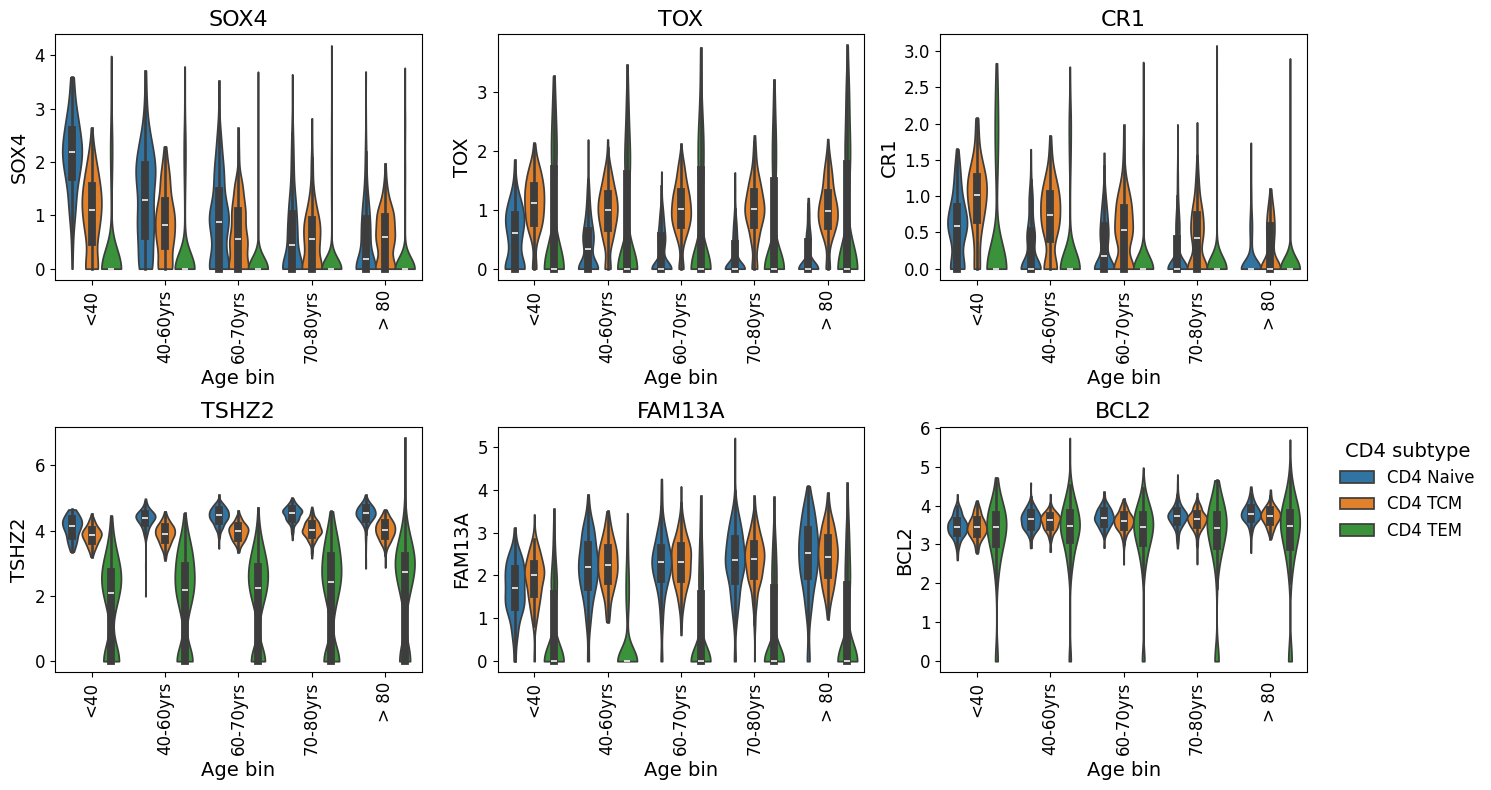

In [8]:
ct = 'CD4T'
pbulk_adata = sc.read_h5ad(datadir + f"Yazar2022_{ct}_processed.pbulk.h5ad")
pbulk_adata.obs_names_make_unique()
pbulk_adata.var['ensembl_id'] = pbulk_adata.var.index
pbulk_adata.var_names = pbulk_adata.var['feature_name']

# Create mapping dictionary for age categories
age_cat_map = {
    1: '<40',
    2: '40-60yrs', 
    3: '60-70yrs',
    4: '70-80yrs',
    5: '> 80'
}

pbulk_adata.obs['age_cat'] = pbulk_adata.obs['age_cat'].map(age_cat_map)

gs = ['SOX4','TOX', 'CR1', 'TSHZ2', 'FAM13A', 'BCL2']
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i, g in enumerate(gs):
    gex_df = sc.get.obs_df(pbulk_adata, [g, 'age_cat', 'predicted.celltype.l2'], layer='log1p_norm')
    # Set order of age categories 
    age_order = ['<40', '40-60yrs', '60-70yrs', '70-80yrs', '> 80']
    sns.violinplot(data=gex_df, x='age_cat', y=g, hue='predicted.celltype.l2', ax=axes[i],
                   order=age_order, legend=False if i < len(gs)-1 else True, cut=0, scale='width')
    axes[i].tick_params(axis='x', rotation=90, labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].set_xlabel('Age bin', fontsize=14)
    axes[i].set_ylabel(g, fontsize=14)
    axes[i].set_title(g, fontsize=16)
    if i == len(gs)-1:
        axes[i].legend(title='CD4 subtype', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize=12, title_fontsize=14)
plt.tight_layout()

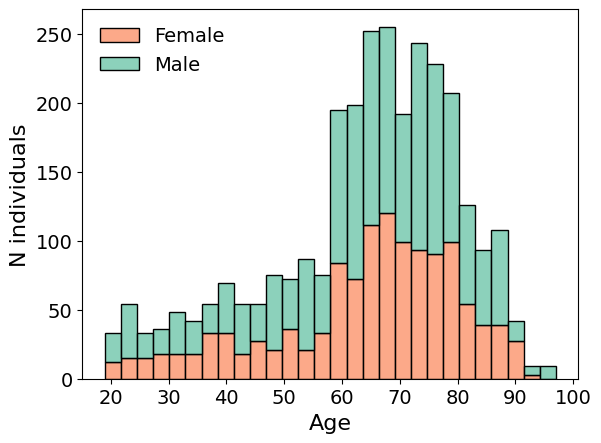

In [76]:
sns.histplot(data=pbulk_adata.obs, x='age', hue='male', multiple='stack', palette='Set2', legend=True)
plt.xlabel('Age', fontsize=16)
plt.ylabel('N individuals', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='', labels=['Female', 'Male'], frameon=False, fontsize=14)

In [14]:
pd.read_csv('/mnt/oak/users/emma/data/GWT/OneK1K_analysis/Yazar2022_NK_processed.metadata.csv')['predicted.celltype.l2'].unique()

array(['NK', 'NK Proliferating', 'NK_CD56bright'], dtype=object)

NaNs encountered, dropping rows with NaNs


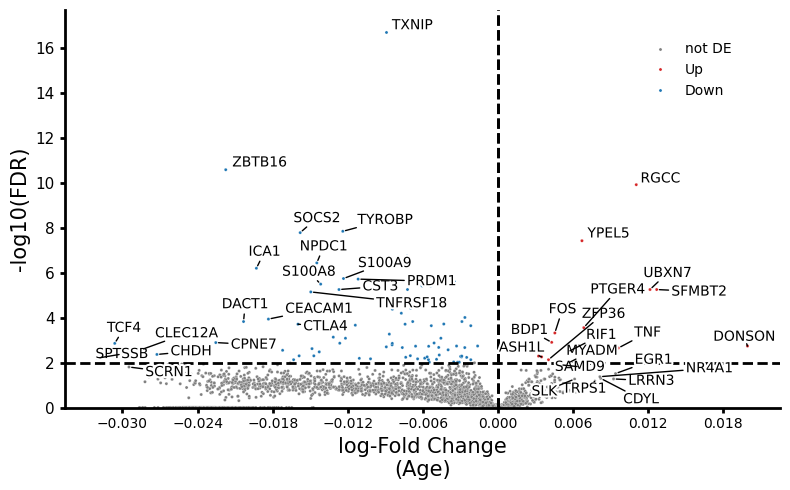

<Figure size 800x2000 with 0 Axes>

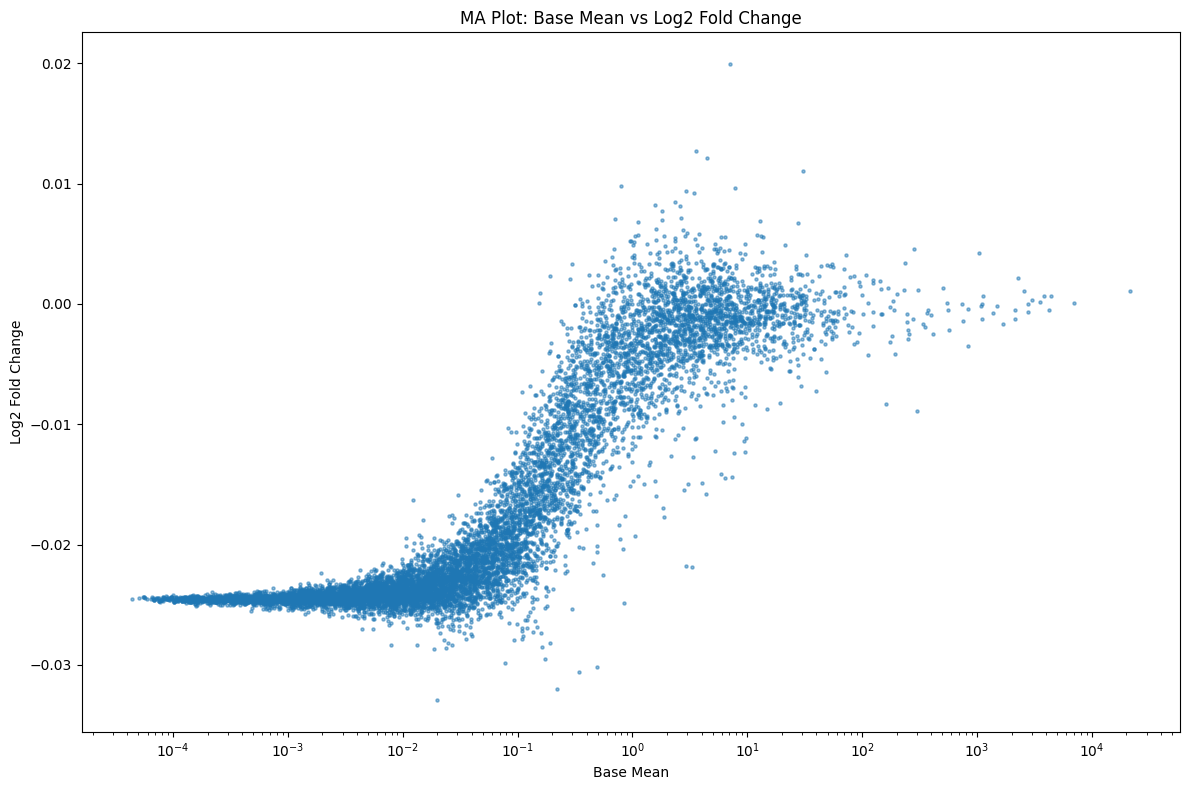

In [90]:
ct = 'CD4T'
pbulk_adata = sc.read_h5ad(datadir + f"Yazar2022_{ct}_processed.pbulk.h5ad")
pbulk_adata.var_names.isin(adata_de_var.index).sum()

res_df = pd.read_csv(f'results/DE_percent_T_cells_{ct}_train.csv')
res_df = res_df.rename({'log2FoldChange':'log_fc', 'padj':'adj_p_value', 'ensembl_id':'variable'}, axis=1)
res_df['gene_name'] = pbulk_adata.var.loc[res_df.variable]['feature_name'].values
res_df['perturbseq_gene'] = res_df['variable'].isin(adata_de_var.index)
res_df['contrast'] = 'age'
res_df['zscore'] = res_df['log_fc']/res_df['lfcSE']
res_df['adj_p_value'] = res_df['adj_p_value'].fillna(1)

onek1k_design = f"~ male + age_cat"
model = pertpy.tl.PyDESeq2(pbulk_adata, design=onek1k_design)

fig = model.plot_volcano(
    res_df[res_df['perturbseq_gene']], 
    log2fc_thresh=0, 
    return_fig=True, 
    to_label = 20,
    symbol_col='gene_name',
    figsize=(8, 5),  # Increased figure size
    s=5,
    pval_thresh=0.01,
    legend_pos = (0.95,0.95),
    y_label = '-log10(FDR)', x_label='log-Fold Change\n(Age)'
    )
fig.tight_layout()  
fig.show()  

plt.figure(figsize=(8,20))
fig = plt.figure(figsize=(12, 8))
plt.scatter(res_df['baseMean'], res_df['log_fc'], alpha=0.5, s=5)
plt.xscale('log')
plt.xlabel('Base Mean')
plt.ylabel('Log2 Fold Change') 
plt.title('MA Plot: Base Mean vs Log2 Fold Change')
fig.tight_layout()
plt.show()

In [72]:
lof_results = pd.read_table('/mnt/oak/users/mineto/workstation/250717_TcellPerturb/BurdenRegCor/GeneLevel/Stim48hr_Backman_LymphocyteCount_fullFeatures.per_gene_estimates.tsv_geneRegulation_correlation.txt')
lof_results.head()

gene             ensg  P_withShet  beta_withShet  betaSE_withShet  \
0    TSPAN6  ENSG00000000003    0.986855       0.000158         0.009610   
1      DPM1  ENSG00000000419    0.006943      -0.025945         0.009609   
2     SCYL3  ENSG00000000457    0.463538       0.007044         0.009609   
3  C1orf112  ENSG00000000460    0.593118      -0.005135         0.009609   
4       FGR  ENSG00000000938    0.749628      -0.003067         0.009609   

   P_pearson  R_pearson  R_pearson_CIlower  R_pearson_CIupper  
0   0.878478   0.001477          -0.017455           0.020408  
1   0.003040  -0.028623          -0.047528          -0.009697  
2   0.432246   0.007586          -0.011347           0.026514  
3   0.532267  -0.006033          -0.024961           0.012900  
4   0.804005  -0.002397          -0.021328           0.016535

/tmp/ipykernel_1321620/3575509495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lof_results_signif['LoF_signif'] = (lof_results_signif['P_pearson'] < 0.01) & (np.abs(lof_results_signif['R_pearson']) > 0.1)
/tmp/ipykernel_1321620/3575509495.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lof_results_signif['abs_R_pearson'] = lof_results_signif['R_pearson'].abs()


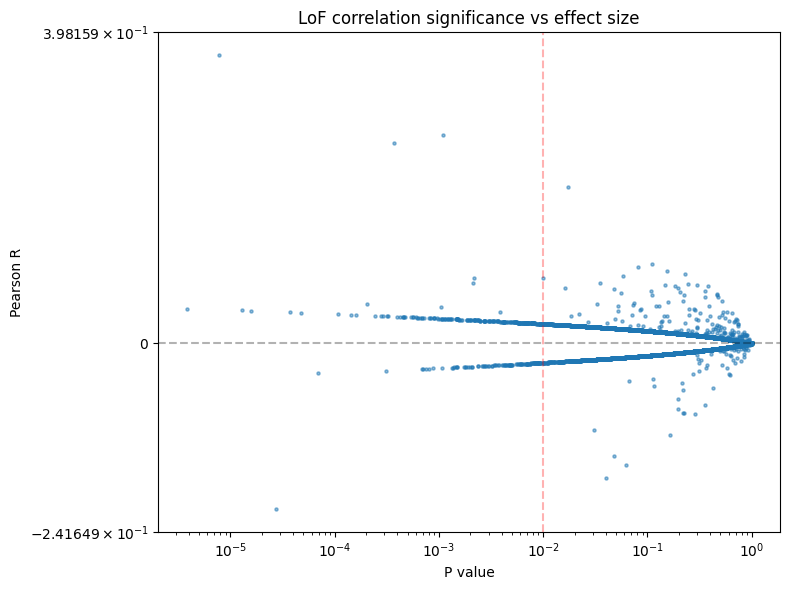

In [102]:
lof_results_signif = lof_results[['ensg', 'P_pearson', 'R_pearson']]
lof_results_signif['LoF_signif'] = (lof_results_signif['P_pearson'] < 0.01) & (np.abs(lof_results_signif['R_pearson']) > 0.1)
lof_results_signif['abs_R_pearson'] = lof_results_signif['R_pearson'].abs()

# lof_results_signif = lof_results_signif[lof_results_signif['P_pearson'] < 0.1].sort_values('abs_R_pearson')
plt.figure(figsize=(8,6))
plt.scatter(lof_results_signif['P_pearson'], lof_results_signif['R_pearson'], alpha=0.5, s=5)
plt.xlabel('P value')
plt.ylabel('Pearson R')
plt.yscale('symlog')
plt.xscale('log')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.axvline(x=0.01, color='red', linestyle='--', alpha=0.3)
plt.title('LoF correlation significance vs effect size')
plt.tight_layout()
plt.show()

Contingency table:
LoF_signif  False  True 
DE_signif               
False       17388   2200
True           98     21

Odds ratio: 1.69 (95% CI: 1.05-2.72)
P-value: 3.99e-02


/tmp/ipykernel_1321620/3384800462.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lof_results_signif['LoF_signif'] = (lof_results_signif['P_pearson'] < 0.1) #& (np.abs(lof_results_signif['R_pearson']) > 0.1)


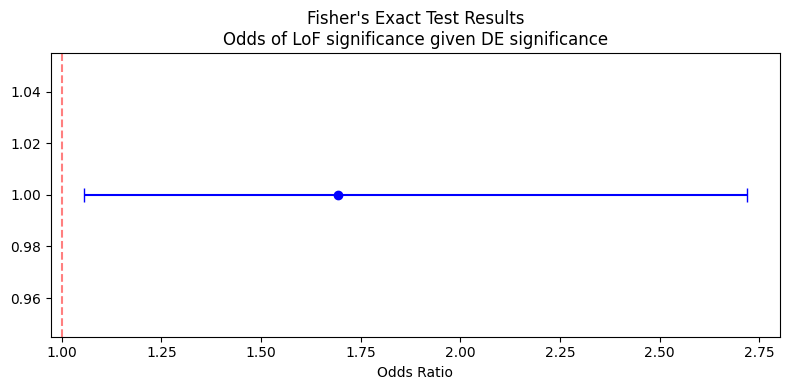

In [107]:


# Create binary indicators for significance
de_results_signif = res_df.rename({'variable':'ensg'}, axis=1)[['ensg', 'adj_p_value']]
de_results_signif['DE_signif'] = de_results_signif['adj_p_value'] < 0.01
lof_results_signif = lof_results[['ensg', 'P_pearson', 'R_pearson']]
lof_results_signif['LoF_signif'] = (lof_results_signif['P_pearson'] < 0.1) #& (np.abs(lof_results_signif['R_pearson']) > 0.1)

# Merge the two dataframes
merged_df = pd.merge(de_results_signif[['ensg', 'DE_signif']], 
                    lof_results_signif[['ensg', 'LoF_signif', 'R_pearson']], 
                    on='ensg', how='outer').fillna(False)

# Create contingency table
contingency = pd.crosstab(merged_df['DE_signif'], merged_df['LoF_signif'])

# Calculate odds of LoF significance given DE significance
de_sig = contingency[True].sum()
de_not_sig = contingency[False].sum()
lof_given_de = contingency.loc[True, True] / de_sig
lof_given_not_de = contingency.loc[False, True] / de_not_sig
odds = lof_given_de / lof_given_not_de

# Perform Fisher's exact test to assess significance and get confidence intervals
from scipy.stats import fisher_exact
import numpy as np

odds_ratio, pvalue = fisher_exact(contingency)
# Calculate 95% confidence intervals for odds ratio
# Using formula from Woolf's method
a = contingency.loc[True, True]
b = contingency.loc[True, False] 
c = contingency.loc[False, True]
d = contingency.loc[False, False]

se = np.sqrt(1/a + 1/b + 1/c + 1/d)
ci_lower = np.exp(np.log(odds_ratio) - 1.96*se)
ci_upper = np.exp(np.log(odds_ratio) + 1.96*se)

print("Contingency table:")
print(contingency)
print(f"\nOdds ratio: {odds_ratio:.2f} (95% CI: {ci_lower:.2f}-{ci_upper:.2f})")
print(f"P-value: {pvalue:.2e}")

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.errorbar(odds_ratio, 1, xerr=[[odds_ratio-ci_lower], [ci_upper-odds_ratio]], 
             fmt='o', capsize=5, color='blue')
plt.axvline(x=1, color='red', linestyle='--', alpha=0.5)
plt.xlabel('Odds Ratio')
plt.title("Fisher's Exact Test Results\nOdds of LoF significance given DE significance")
plt.tight_layout()
plt.show()


In [121]:
res_df

variable     baseMean    log_fc     lfcSE      stat    pvalue  \
0     ENSG00000230699     0.017334 -0.024419  0.035624 -0.685456  0.493056   
1     ENSG00000241180     0.000131 -0.024417  0.178545 -0.136756  0.891224   
2     ENSG00000188290     0.368400 -0.013702  0.005200 -2.635239  0.008408   
3     ENSG00000187608    24.963828 -0.003752  0.001444 -2.599356  0.009340   
4     ENSG00000285812     0.018120 -0.022598  0.030375 -0.743955  0.456904   
...               ...          ...       ...       ...       ...       ...   
9995  ENSG00000198804  1374.936621 -0.000776  0.000506 -1.534183  0.124985   
9996  ENSG00000198712  1096.856917 -0.001240  0.000445 -2.787653  0.005309   
9997  ENSG00000198938  1108.887960  0.000011  0.000508  0.022189  0.982297   
9998  ENSG00000198840   734.170344 -0.000001  0.000683 -0.002112  0.998315   
9999  ENSG00000198727   758.596931 -0.001405  0.000543 -2.585258  0.009731   

      adj_p_value      gene_name  perturbseq_gene contrast    zscore  
0        1.000000    RP11-54O7.1            False      age -0.685456  
1        1.000000    RP11-54O7.2            False      age -0.136756  
2        0.059948           HES4             True      age -2.635239  
3        0.060927          ISG15             True      age -2.599356  
4        1.000000  RP11-465B22.9            False      age -0.743955  
...           ...            ...              ...      ...       ...  
9995     0.216700         MT-CO1            False      age -1.534183  
9996     0.049536         MT-CO2            False      age -2.787653  
9997     0.988679         MT-CO3            False      age  0.022189  
9998     0.998350         MT-ND3            False      age -0.002112  
9999     0.061986         MT-CYB            False      age -2.585258  

[10000 rows x 11 columns]

<Axes: xlabel='log_fc', ylabel='R_pearson'>

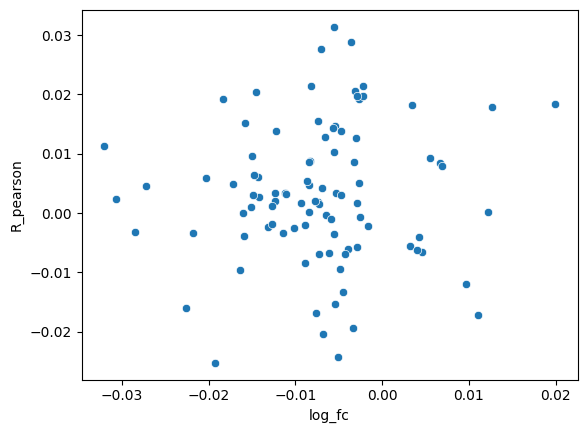

In [127]:
# Merge DE and LoF results
de_results_signif = res_df.rename({'variable':'ensg'}, axis=1)[['ensg', 'adj_p_value', 'log_fc']]
lof_results_signif = lof_results[['ensg', 'P_pearson', 'R_pearson']]

merged_df = pd.merge(de_results_signif[['ensg', 'log_fc', 'adj_p_value']], 
                    lof_results_signif[['ensg', 'R_pearson']], 
                    on='ensg', how='inner')

sns.scatterplot(data=merged_df[merged_df['adj_p_value'] < 0.01], x='log_fc', y='R_pearson')

array(['ENSG00000186891', 'ENSG00000070831', 'ENSG00000000938',
       'ENSG00000142937', 'ENSG00000143013', 'ENSG00000116489',
       'ENSG00000276216', 'ENSG00000265972', 'ENSG00000163220',
       'ENSG00000163221', 'ENSG00000143546', 'ENSG00000197956',
       'ENSG00000116539', 'ENSG00000158869', 'ENSG00000163041',
       'ENSG00000203667', 'ENSG00000119801', 'ENSG00000250565',
       'ENSG00000034510', 'ENSG00000222041', 'ENSG00000080345',
       'ENSG00000163599', 'ENSG00000091317', 'ENSG00000144674',
       'ENSG00000114737', 'ENSG00000016391', 'ENSG00000196542',
       'ENSG00000145012', 'ENSG00000163960', 'ENSG00000243449',
       'ENSG00000152969', 'ENSG00000004468', 'ENSG00000163453',
       'ENSG00000138640', 'ENSG00000170006', 'ENSG00000171522',
       'ENSG00000145734', 'ENSG00000007944', 'ENSG00000232810',
       'ENSG00000227507', 'ENSG00000137193', 'ENSG00000057657',
       'ENSG00000075624', 'ENSG00000003147', 'ENSG00000158517',
       'ENSG00000105810', 'ENSG000002335

In [139]:
de_gs = de_results_signif[de_results_signif['adj_p_value'] < 0.01].ensg.unique()
lof_results['DE_gene'] = lof_results['ensg'].isin(de_gs)
lof_results.sort_values("P_withShet")[50:100]

gene             ensg  P_withShet  beta_withShet  betaSE_withShet  \
975        SIDT1  ENSG00000072858    0.000926       0.031818         0.009604   
5157      GIMAP4  ENSG00000133574    0.000941       0.031776         0.009605   
834        HDAC4  ENSG00000068024    0.000954       0.031757         0.009609   
6189      RNF157  ENSG00000141576    0.000976       0.031679         0.009605   
7137       PDE3B  ENSG00000152270    0.000981       0.031668         0.009605   
12198     GIMAP1  ENSG00000213203    0.001007       0.031609         0.009609   
269          MVP  ENSG00000013364    0.001010       0.031596         0.009607   
2624      TGFBR1  ENSG00000106799    0.001010       0.031584         0.009604   
1932        STK4  ENSG00000101109    0.001074       0.031418         0.009604   
11095       HPDL  ENSG00000186603    0.001086      -0.031390         0.009605   
4510       EVI2A  ENSG00000126860    0.001126       0.031292         0.009605   
12141  KRTAP22-2  ENSG00000206106    0.001129       0.031281         0.009604   
8670        TPP1  ENSG00000166340    0.001131       0.031287         0.009607   
7204        CAST  ENSG00000153113    0.001145       0.031247         0.009606   
4912       TRAF3  ENSG00000131323    0.001159       0.031222         0.009608   
11461     MAN2A2  ENSG00000196547    0.001162       0.031204         0.009604   
1217      STK17B  ENSG00000081320    0.001301       0.030896         0.009605   
8340       ERAP2  ENSG00000164308    0.001340       0.030814         0.009605   
8075       BOLA3  ENSG00000163170    0.001356      -0.030778         0.009604   
51       NDUFAB1  ENSG00000004779    0.001378      -0.030734         0.009604   
8133       EOMES  ENSG00000163508    0.001396       0.030701         0.009605   
3501        SOS1  ENSG00000115904    0.001426       0.030652         0.009608   
3315      PDCD10  ENSG00000114209    0.001440      -0.030614         0.009604   
472       INPP4A  ENSG00000040933    0.001472       0.030552         0.009605   
1586        ADA2  ENSG00000093072    0.001505       0.030493         0.009606   
910        NDST1  ENSG00000070614    0.001512      -0.030477         0.009605   
8759     ANKDD1A  ENSG00000166839    0.001516       0.030471         0.009605   
9665        SSH3  ENSG00000172830    0.001600       0.030322         0.009606   
4065      MTERF4  ENSG00000122085    0.001613      -0.030298         0.009605   
4609       APOL3  ENSG00000128284    0.001677       0.030187         0.009605   
37         MTMR7  ENSG00000003987    0.001678       0.030186         0.009605   
1639        JAK2  ENSG00000096968    0.001747       0.030073         0.009605   
6133     PRPSAP2  ENSG00000141127    0.001756      -0.030064         0.009607   
12434     UQCRHL  ENSG00000233954    0.001775      -0.030027         0.009605   
9199      OR4K15  ENSG00000169488    0.001807       0.030020         0.009619   
5237       YWHAQ  ENSG00000134308    0.001842      -0.029933         0.009608   
3107       ULBP1  ENSG00000111981    0.001870      -0.029880         0.009605   
4234        TOX2  ENSG00000124191    0.001889      -0.029850         0.009605   
6373        ENSA  ENSG00000143420    0.001902      -0.029831         0.009605   
1013        MGLL  ENSG00000074416    0.001909      -0.029823         0.009606   
3244        SUB1  ENSG00000113387    0.001963      -0.029748         0.009607   
1084       ICAM3  ENSG00000076662    0.001964       0.029742         0.009605   
854        KIF2A  ENSG00000068796    0.001994      -0.029710         0.009609   
5756       IFI44  ENSG00000137965    0.002019       0.029661         0.009605   
9357         EMB  ENSG00000170571    0.002040       0.029631         0.009605   
8260       H2AZ1  ENSG00000164032    0.002048      -0.029620         0.009604   
9826        TLR6  ENSG00000174130    0.002065       0.029619         0.009612   
7838    PPP1R16A  ENSG00000160972    0.002071      -0.029589         0.009605   
5979       LPAR6  ENSG00000139679    0.0020

### Read perturb-seq results

In [7]:
# Import utility functions from DE_analysis_utils.py
import sys
sys.path.append(os.path.abspath('../3_DE_analysis'))
from DE_analysis_utils import get_DE_results_long


In [8]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'
experiment_name = 'CD4i_final'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')

adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50
for cond in adata_de.obs.culture_condition.unique():
    affected_gs_cond = np.sum(adata_de[adata_de.obs['culture_condition'] == cond].layers['adj_p_value'] < 0.1, axis=0)
    adata_de.var[f'n_signif_effects_{cond}'] = affected_gs_cond
    
adata_de.var_names = adata_de.var['gene_name'].values
adata_de.var_names

Index(['TSPAN6', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2', 'GCLC',
       'NFYA', 'STPG1',
       ...
       'ARHGAP11B', 'LINC02929', 'CDR1', 'PRRC2B', 'F8A1', 'HOMEZ', 'C2orf83',
       'ENSG00000290797', 'ENSG00000291096', 'SOD2'],
      dtype='object', length=13959)

In [11]:
# Load summary stats
DE_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)
DE_stats = DE_stats[DE_stats['condition'] == 'Rest']
keep_targets = DE_stats[ (DE_stats.n_total_de_genes > 1)].target_name.tolist()
print(len(keep_targets))

adata_de = adata_de[adata_de.obs['target_contrast_gene_name'].isin(keep_targets)].copy()

6896


In [12]:
adata_de

AnnData object with n_obs × n_vars = 20490 × 13959
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target'
    var: 'gene_ids', 'gene_name', 'n_signif_effects_Stim8hr', 'n_signif_effects_Stim48hr', 'n_signif_effects_Rest'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

## Train model on perturbation effetcs

In [13]:
from pert2state_model.Perturb2StateModel import Perturb2StateModel

In [14]:
def eval_splits_on_repl(model, X_perturbs, y_target, y_target_repl, state_name=None):
    """
    Calculate correlations between predictions and true values for each split of a model.
    
    Parameters
    ----------
    model : object
        Model object with get_prediction() and split_ixs attributes
    y_target : pd.Series
        Target values used for training
    y_target_repl : pd.Series
        Replicate target values to compare against
    state_name : str, optional
        Name of the state to include in output dataframe
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing correlation metrics for each split
    """
    # Get predictions for each split
    splits_pred = model.get_prediction(X_perturbs, return_splits=True)
    
    # Get test indices for each split
    test_indices = [x[1] for x in model.split_ixs]
    
    # Compare predictions to true values for each test split
    all_split_corrs = None
    for i, test_idx in enumerate(test_indices):
        # Get predictions for this split from the corresponding column
        test_pred = splits_pred.iloc[test_idx, i]
        test_true = y_target_repl.iloc[test_idx]
        test_input = y_target.iloc[test_idx]
        
        # Calculate correlation for this split
        corr = np.corrcoef(test_pred, test_true)[0,1]
        top_corr = np.corrcoef(test_input, test_true)[0,1]
        
        # Store correlation in dataframe
        split_corr_df = pd.DataFrame({
            'split': i,
            'correlation': corr,
            'upper_correlation': top_corr,
            'state': state_name
        }, index=[0])
        
        if all_split_corrs is None:
            all_split_corrs = split_corr_df
        else:
            all_split_corrs = pd.concat([all_split_corrs, split_corr_df])
            
    return all_split_corrs

### Reconstruction performance

Common genes between target and adata_de: 3299

Training models for condition: Stim8hr
Perturbation matrix shape: (3299, 6846)
Training model with 50 PCs, 5 splits, 3 repeats
Model training for age completed successfully

Training models for condition: Stim48hr
Perturbation matrix shape: (3299, 6748)
Training model with 50 PCs, 5 splits, 3 repeats


KeyboardInterrupt: 

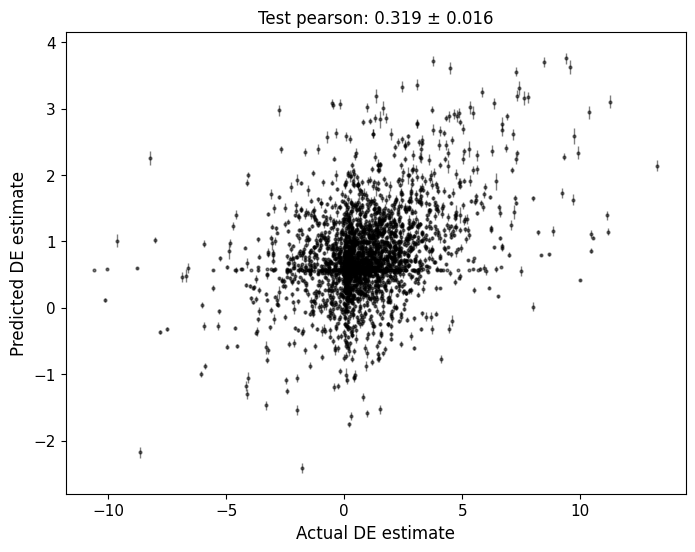

In [ ]:
ct_classes = ['CD4T', 'CD8T', 'NK']
perturb_layer = 'zscore'
target_state = 'age'
signif_zscore = 0
n_pcs=50
n_splits=5
n_repeats=3

results_df = pd.DataFrame()
models = {}

for ct in ct_classes:
    train_df = train_results[ct]
    train_df['contrast'] = target_state

    # Get target state values
    y_target = train_df.pivot_table(index='gene_name', columns='contrast', values=perturb_layer)[target_state]
    y_target = y_target[train_df.pivot_table(index='gene_name', columns='contrast', values='adj_p_value')[target_state] < 0.1]
    # y_target = y_target[train_df.pivot_table(index='gene_name', columns='contrast', values=perturb_layer)[target_state].abs() > 0.5]
    val_df = val_results[ct]
    val_df['contrast'] = target_state
    y_target_val = val_df.pivot_table(index='gene_name', columns='contrast', values=perturb_layer)[target_state]
    common_genes = np.intersect1d(y_target.index, y_target_val.index)
    y_target_val = y_target_val.loc[common_genes]
    y_target = y_target.loc[common_genes]
    
    # Find common genes between all DE results
    common_gs = np.intersect1d(y_target.index, adata_de.var_names)
    print(f"Common genes between target and adata_de: {len(common_gs)}")
    y_target = y_target.loc[common_gs]

    # Train models for each condition
    for cond in adata_de.obs.culture_condition.unique():
        print(f"\nTraining models for condition: {cond}")
        
        # Get responses for this condition
        X_perturbs = sc.get.obs_df(adata_de[adata_de.obs.culture_condition == cond], 
                                ['target_contrast_gene_name'] + list(common_gs), 
                                layer=perturb_layer)
        X_perturbs = X_perturbs.set_index('target_contrast_gene_name').T
        print(f"Perturbation matrix shape: {X_perturbs.shape}")

        # Mask effects in cis and based on zscore thresh
        X_perturbs_masked = X_perturbs.copy()
        mask = pd.DataFrame(False, index=X_perturbs_masked.index, columns=X_perturbs_masked.columns)
        # Mask cis effects
        for idx in X_perturbs_masked.index:
            if idx in X_perturbs_masked.columns:
                mask.loc[idx, idx] = True
        # Mask non-significant effects
        # mask = mask | (np.abs(X_perturbs) < signif_zscore)
        X_perturbs_masked = X_perturbs_masked.mask(mask)
        # Impute masked values with column means
        X_perturbs_masked = X_perturbs_masked.fillna(0)

        # Train main model
        print(f"Training model with {n_pcs} PCs, {n_splits} splits, {n_repeats} repeats")
        p2t_model = Perturb2StateModel(pca_transform=True, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=False)
        p2t_model.fit(X_perturbs_masked, y_target, model_id=f'{ct}_{cond}', stratify_y=False)
        models[f'{ct}_{cond}'] = p2t_model
        p2t_model.plot_prediction(X_perturbs_masked, y_target, plot_metric='pearson')
        print(f"Model training for {target_state} completed successfully")

        # Eval on validation set
        y_target_val = y_target_val.loc[common_gs]
        val_reconstr = eval_splits_on_repl(p2t_model,X_perturbs_masked, y_target, y_target_val, state_name=cond)
        val_reconstr['cell_type_class'] = ct
        val_reconstr['target_data'] = 'validation'
        results_df = pd.concat([results_df, val_reconstr])


In [22]:
import pickle
with open('aging_models.pkl', 'wb') as f:
    pickle.dump(models, f)

{'CD4T_Rest': <pert2state_model.Perturb2StateModel.Perturb2StateModel at 0x7fa410ac3ec0>}

{'CD4T_Stim8hr': <pert2state_model.Perturb2StateModel.Perturb2StateModel at 0x7fa41abd8c80>,
 'CD4T_Stim48hr': <pert2state_model.Perturb2StateModel.Perturb2StateModel at 0x7fa5313bddc0>,
 'CD4T_Rest': <pert2state_model.Perturb2StateModel.Perturb2StateModel at 0x7fa41abdb7a0>,
 'CD8T_Stim8hr': <pert2state_model.Perturb2StateModel.Perturb2StateModel at 0x7fa4042bd250>,
 'CD8T_Stim48hr': <pert2state_model.Perturb2StateModel.Perturb2StateModel at 0x7fa417f1d2b0>,
 'CD8T_Rest': <pert2state_model.Perturb2StateModel.Perturb2StateModel at 0x7fa41acf0920>,
 'NK_Stim8hr': <pert2state_model.Perturb2StateModel.Perturb2StateModel at 0x7fa4181dfe60>,
 'NK_Stim48hr': <pert2state_model.Perturb2StateModel.Perturb2StateModel at 0x7fa417cf97f0>,
 'NK_Rest': <pert2state_model.Perturb2StateModel.Perturb2StateModel at 0x7fa41b334cb0>}

Common genes between target and adata_de: 633
Perturbation matrix shape: (633, 5586)


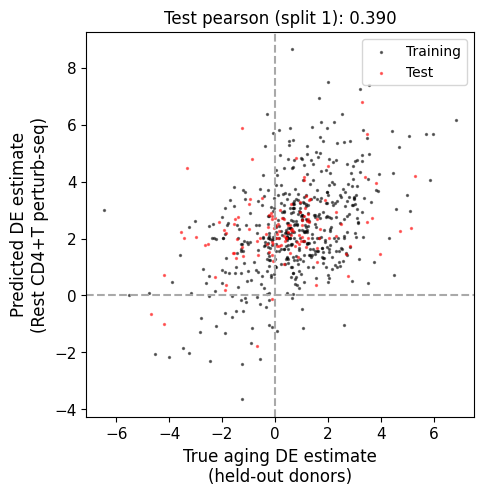

In [103]:
ct = 'CD4T'
cond = 'Rest'
p2t_model = models[f'{ct}_{cond}']

train_df = train_results[ct]
train_df['contrast'] = target_state
y_target = train_df.pivot_table(index='gene_name', columns='contrast', values=perturb_layer)[target_state]
y_target = y_target[train_df.pivot_table(index='gene_name', columns='contrast', values='adj_p_value')[target_state] < 0.1]

val_df = val_results[ct]
val_df['contrast'] = target_state
y_target_val = val_df.pivot_table(index='gene_name', columns='contrast', values=perturb_layer)[target_state]
common_genes = np.intersect1d(y_target.index, y_target_val.index)
y_target_val = y_target_val.loc[common_genes]
y_target = y_target.loc[common_genes]

common_gs = np.intersect1d(y_target.index, adata_de.var_names)
print(f"Common genes between target and adata_de: {len(common_gs)}")
y_target = y_target.loc[common_gs]
y_target_val = y_target_val.loc[common_gs]

val_df = val_results[ct]
val_df['contrast'] = target_state
y_target_val = val_df.pivot_table(index='gene_name', columns='contrast', values=perturb_layer)[target_state]
common_genes = np.intersect1d(y_target.index, y_target_val.index)

# Get responses for this condition
X_perturbs = sc.get.obs_df(adata_de[adata_de.obs.culture_condition == cond], 
                        ['target_contrast_gene_name'] + list(common_gs), 
                        layer=perturb_layer)
X_perturbs = X_perturbs.set_index('target_contrast_gene_name').T
print(f"Perturbation matrix shape: {X_perturbs.shape}")

# Mask effects in cis
X_perturbs_masked = X_perturbs.copy()
mask = pd.DataFrame(False, index=X_perturbs_masked.index, columns=X_perturbs_masked.columns)
for idx in X_perturbs_masked.index:
    if idx in X_perturbs_masked.columns:
        mask.loc[idx, idx] = True
X_perturbs_masked = X_perturbs_masked.mask(mask)
X_perturbs_masked = X_perturbs_masked.fillna(0)

y_target_val = y_target_val.loc[common_genes]
y_target = y_target.loc[common_genes]

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
p2t_model.plot_prediction(X_perturbs_masked, y_target_val, split_id=1, return_ax=True, ax=axes, plot_metric='pearson')
axes.set_ylabel('Predicted DE estimate\n(Rest CD4+T perturb-seq)', fontsize=12)
axes.set_xlabel(f'True aging DE estimate\n(held-out donors)', fontsize=12)
axes.axhline(y=0, color='darkgrey', linestyle='--')
axes.axvline(x=0, color='darkgrey', linestyle='--')

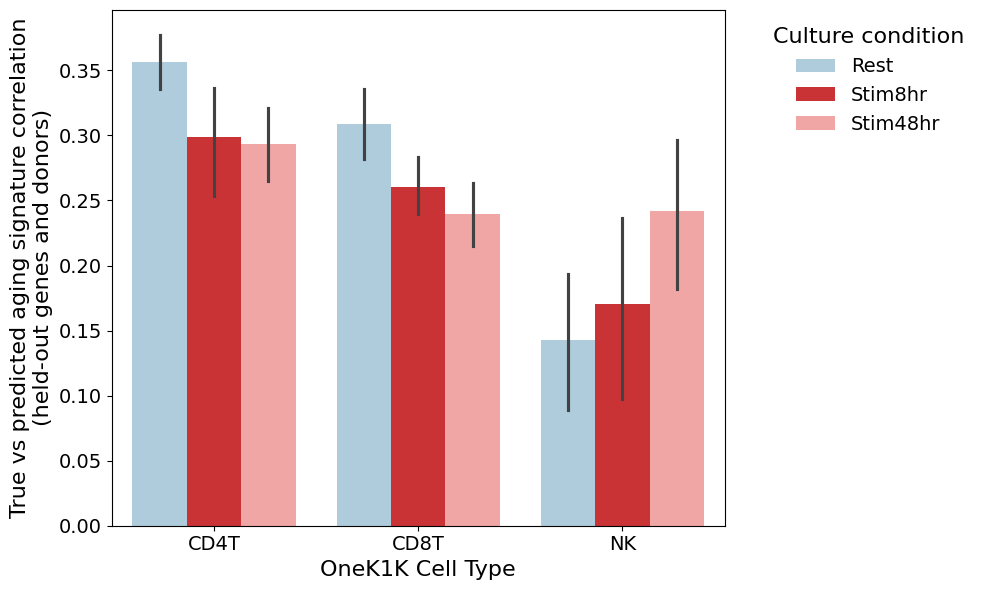

In [38]:
fig, ax = plt.subplots(figsize=(10,6))

# Create barplot
sns.barplot(data=results_df.fillna(0), y='correlation', x='cell_type_class', hue='state',
            ax=ax, palette=palettes['culture_condition'],
            hue_order=['Rest', 'Stim8hr', 'Stim48hr'])
# # Add stripplot
# sns.stripplot(data=results_df.fillna(0), y='correlation', x='cell_type_class', hue='state',
#               dodge=True, ax=ax, size=4, alpha=0.4, color='black',
#               hue_order=['Rest', 'Stim8hr', 'Stim48hr'], legend=False)

# Add dotted lines for upper correlation values
for cell_type in results_df.cell_type_class.unique():
    cell_type_data = results_df[results_df.cell_type_class == cell_type]
    # for i, state in enumerate(['Rest', 'Stim8hr', 'Stim48hr']):
    #     state_data = cell_type_data[cell_type_data.state == state]
    #     if not state_data.empty:
    #         x_pos = ax.get_xticks()[list(results_df.cell_type_class.unique()).index(cell_type)]
    #         # Adjust x position based on hue position
    #         width = 0.8 / 3  # Approximate width of each hue bar
    #         x_adj = x_pos - width + (i * width)
    #         upper_corr = state_data.upper_correlation.mean()
    #         ax.hlines(y=upper_corr, xmin=x_adj-width/2, xmax=x_adj+width/2, 
    #                  colors='black', linestyles='dotted', linewidth=2)

# Customize fonts and labels
plt.xlabel('OneK1K Cell Type', fontsize=16)
plt.ylabel('True vs predicted aging signature correlation\n(held-out genes and donors)', fontsize=16) 
ax.tick_params(axis='both', labelsize=14)

# Adjust legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, frameon=False, title='Culture condition', title_fontsize=16)
plt.tight_layout()


Compare baseline expression

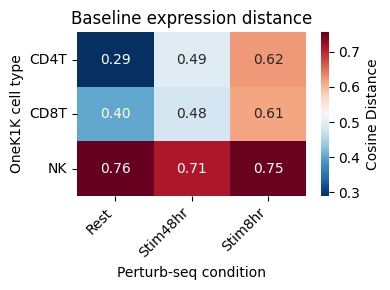

In [153]:
# Comparison of baseline mean expression
pseq_base_means = get_DE_results_long(adata_de, targets=['GATA3'], effect_estimates='baseMean', gene_id_col='gene_ids')
pseq_base_means = pseq_base_means.pivot(columns='culture_condition', index='gene_ids', values='baseMean').dropna()
onek1k_base_means = pd.concat([x[['variable', 'baseMean']].set_index('variable').rename({'baseMean':k}, axis=1) for k,x in train_results.items()], axis=1)
all_base_means = pd.concat([pseq_base_means, onek1k_base_means], axis=1).dropna()
from scipy.spatial.distance import pdist, squareform
base_means_dist = pd.DataFrame(squareform(pdist(all_base_means.T)), 
                             index=all_base_means.columns,
                             columns=all_base_means.columns)
pseq_cols = pseq_base_means.columns
onek1k_cols = onek1k_base_means.columns

# Calculate cosine distances between conditions
from scipy.spatial.distance import cosine
dist_long = pd.DataFrame([
    {'onek1k_condition': col1,
     'pseq_condition': col2, 
     'distance': cosine(all_base_means[col1], all_base_means[col2])}
    for col1 in onek1k_cols
    for col2 in pseq_cols
])

# Create heatmap
plt.figure(figsize=(4,3))
sns.heatmap(data=dist_long.pivot(index='onek1k_condition', columns='pseq_condition', values='distance'),
            cmap='RdBu_r', annot=True, fmt='.2f',
            cbar_kws={'label': 'Cosine Distance'})
plt.xticks(rotation=45, ha='right');
plt.yticks(rotation=0);
plt.xlabel('Perturb-seq condition');
plt.ylabel('OneK1K cell type');
plt.title('Baseline expression distance');
plt.tight_layout()

<Axes: >

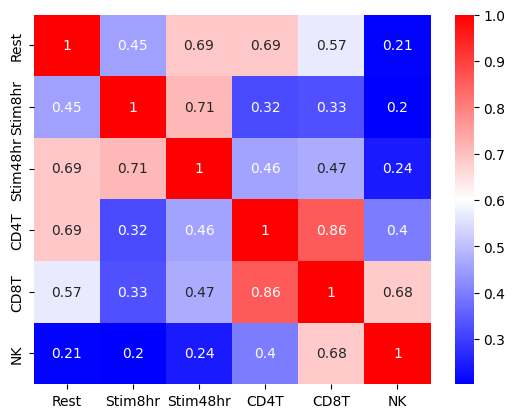

In [130]:
sns.heatmap(all_base_means.corr(), cmap='bwr', annot=True)

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.0, 'Top 20 Principal Components')

<Figure size 1200x800 with 0 Axes>

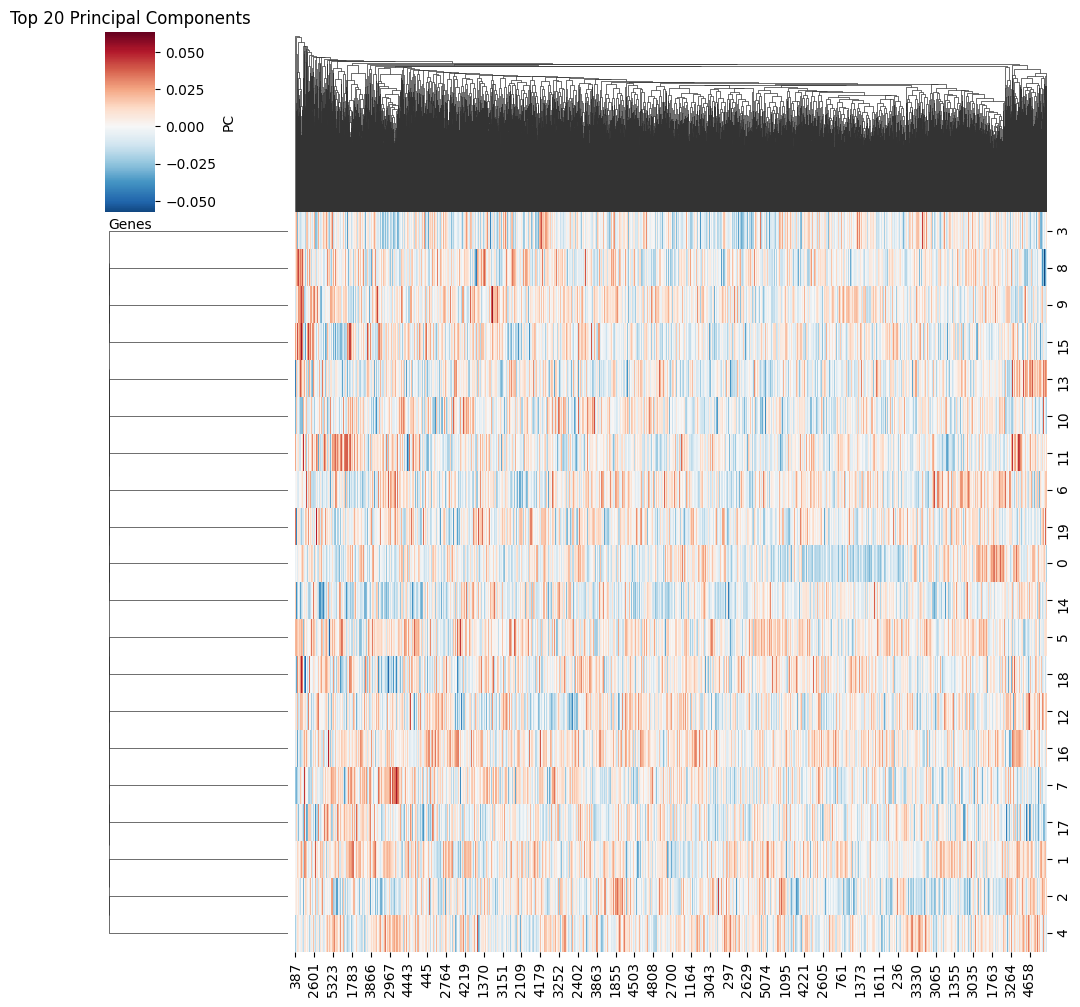

In [154]:
# Get top 20 components and plot as heatmap
components = p2t_model.pcas[0].components_[:20]
plt.figure(figsize=(12, 8))
sns.clustermap(components, cmap='RdBu_r', center=0)
plt.xlabel('Genes')
plt.ylabel('PC')
plt.title('Top 20 Principal Components')

## Train best model

Common genes between target and adata_de: 3299

Training models for condition: Rest
Perturbation matrix shape: (3299, 6896)
Training model with 30 PCs, 5 splits, 1 repeats
Model training for age completed successfully


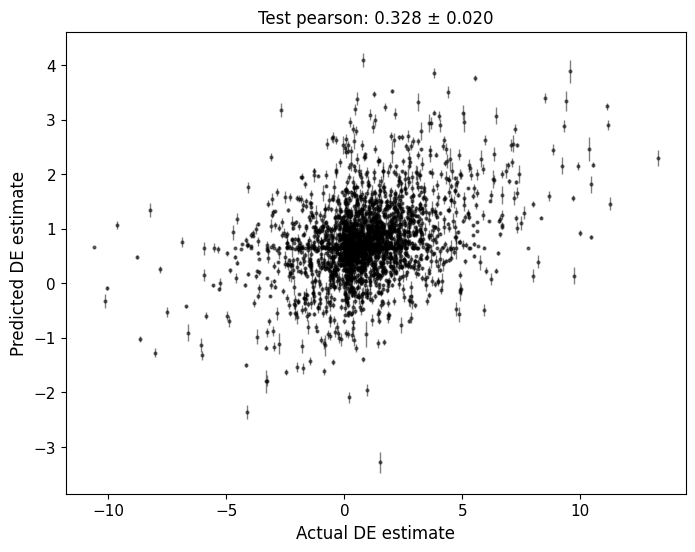

In [221]:
perturb_layer = 'zscore'
target_state = 'age'
signif_zscore = 0
n_pcs=50
n_splits=5
n_repeats=1

ct = 'CD4T'
cond = 'Rest'

train_df = train_results[ct]
train_df['contrast'] = target_state

# Get target state values
y_target = train_df.pivot_table(index='gene_name', columns='contrast', values=perturb_layer)[target_state]
# y_target = y_target[train_df.pivot_table(index='gene_name', columns='contrast', values='adj_p_value')[target_state] < 0.1]
common_genes = np.intersect1d(y_target.index, y_target_val.index)
y_target = y_target.loc[common_genes]

# Find common genes between all DE results
common_gs = np.intersect1d(y_target.index, adata_de.var_names)
print(f"Common genes between target and adata_de: {len(common_gs)}")
y_target = y_target.loc[common_gs]

print(f"\nTraining models for condition: {cond}")

# Get responses for this condition
X_perturbs = sc.get.obs_df(adata_de[adata_de.obs.culture_condition == cond], 
                        ['target_contrast_gene_name'] + list(common_gs), 
                        layer=perturb_layer)
X_perturbs = X_perturbs.set_index('target_contrast_gene_name').T
print(f"Perturbation matrix shape: {X_perturbs.shape}")

# Mask effects in cis and based on zscore thresh
X_perturbs_masked = X_perturbs.copy()
mask = pd.DataFrame(False, index=X_perturbs_masked.index, columns=X_perturbs_masked.columns)
# Mask cis effects
for idx in X_perturbs_masked.index:
    if idx in X_perturbs_masked.columns:
        mask.loc[idx, idx] = True
# Mask non-significant effects
# mask = mask | (np.abs(X_perturbs) < signif_zscore)
X_perturbs_masked = X_perturbs_masked.mask(mask)
# Impute masked values with column means
X_perturbs_masked = X_perturbs_masked.fillna(0)

# Train main model
print(f"Training model with {n_pcs} PCs, {n_splits} splits, {n_repeats} repeats")
p2t_model = Perturb2StateModel(pca_transform=True, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=False)
p2t_model.fit(X_perturbs_masked, y_target, model_id=f'{ct}_{cond}', stratify_y=False)
models[f'{ct}_{cond}'] = p2t_model
p2t_model.plot_prediction(X_perturbs_masked, y_target, plot_metric='pearson')
print(f"Model training for {target_state} completed successfully")


In [224]:
## Need to test robustness of coefficients

<Axes: xlabel='Model coefficient'>

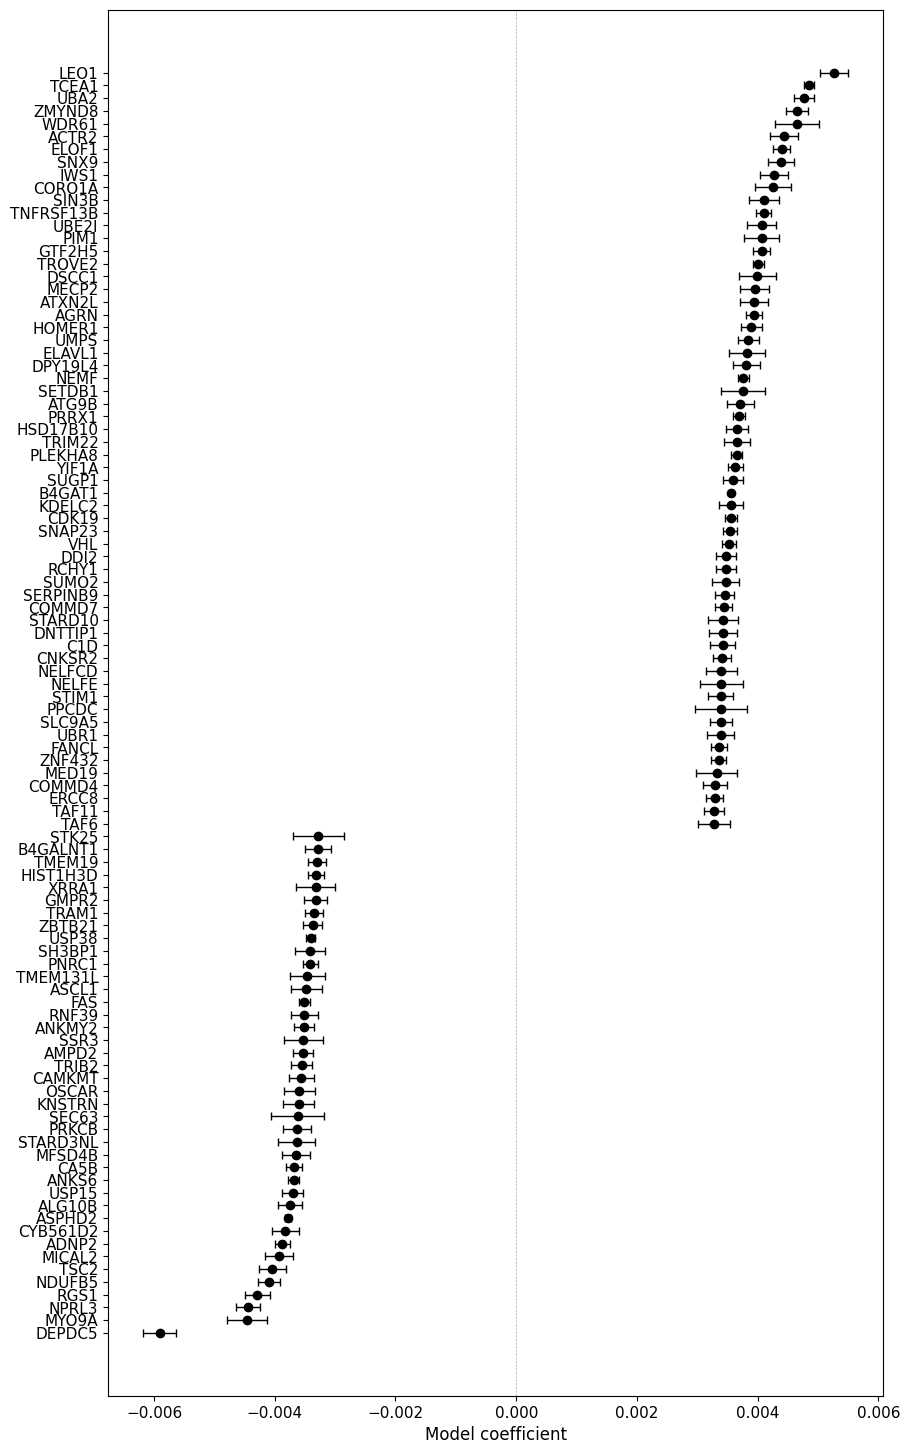

In [222]:
fig, ax = plt.subplots(1, 1, figsize=(10, 18))
p2t_model.plot_coefs(top_n=100,ax=ax, return_ax=True,  show_labels=True)

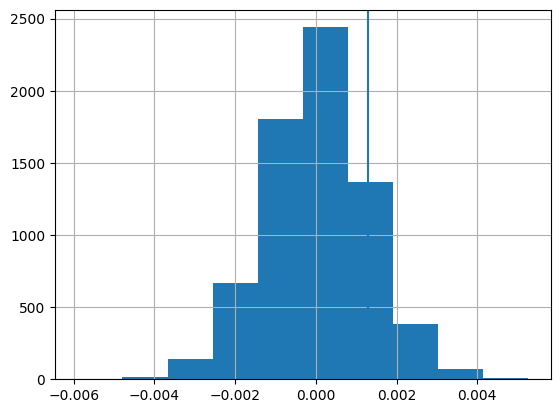

In [223]:
coefs_df = p2t_model.get_coefs()

coefs_df['coef_mean'].hist()
plt.axvline(coefs_df.loc['MED12'][0])

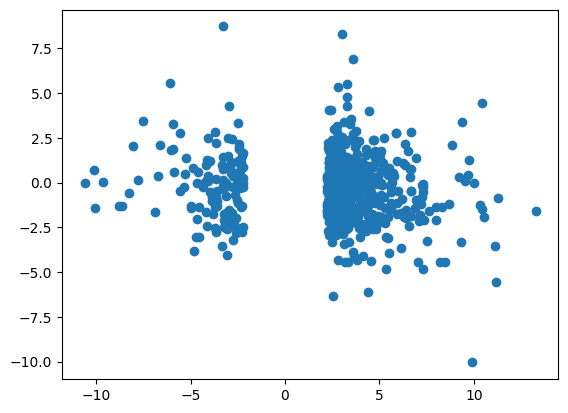

In [214]:
# Get target state values
y_target = train_df.pivot_table(index='gene_name', columns='contrast', values=perturb_layer)[target_state]
y_target = y_target.loc[common_gs]
plt.scatter(y_target, X_perturbs['TSC2'])

### Plot DE effects of predicted regulators

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

st = 'age'
top_quant = 0.005
alpha = 0.01
c = "Rest"

# Get top DE genes for input signature
train_df = train_results[ct]
train_df['contrast'] = target_state

# Get target state values
state_results_df = train_df
signature_effect_size = state_results_df[(state_results_df['adj_p_value'] < alpha) & 
                                       (abs(state_results_df['zscore']) > 5)].sort_values('zscore')
signature_gs = signature_effect_size.gene_name.tolist()

# Get top and bottom 10% of coefficient values
n = len(p2t_model.get_coefs()['coef_mean'])
st_coefs = p2t_model.get_coefs()
top_10_percent = st_coefs['coef_mean'].nlargest(int(n * top_quant))
bottom_10_percent = st_coefs['coef_mean'].nsmallest(int(n * top_quant))
predicted_effect_size = pd.concat([top_10_percent, bottom_10_percent]).sort_values(ascending=False)
predicted_regulators = predicted_effect_size.index.tolist()

# Get DE results and pivot to wide format
long_de_results = get_DE_results_long(adata_de, targets=predicted_regulators, genes=signature_gs, gene_id_col='gene_name')
long_de_results = long_de_results[long_de_results['culture_condition'] == c].copy()
wide_de_results = long_de_results.pivot(index='gene', columns='target_contrast_gene_name', values='zscore')
wide_de_results_signif = long_de_results.pivot(index='gene', columns='target_contrast_gene_name', values='adj_p_value')

# Create a mask for diagonal values and low zscore values
mask = pd.DataFrame(False, index=wide_de_results.index, columns=wide_de_results.columns)
for idx in wide_de_results.index:
    if idx in wide_de_results.columns:
        mask.loc[idx, idx] = True
# Add mask for abs zscore < 1
mask = mask | (wide_de_results.abs() < 0)
wide_de_results = wide_de_results.mask(mask, 0)
wide_de_results = wide_de_results.T

# Define axis labels
wide_de_results.index.name = 'Regulators (CRISPRi targets)'
wide_de_results.columns.name = f'{st} signature genes ({alpha*100}% FDR)'
wide_de_results = wide_de_results.dropna(axis=1)


<Figure size 3000x2000 with 0 Axes>

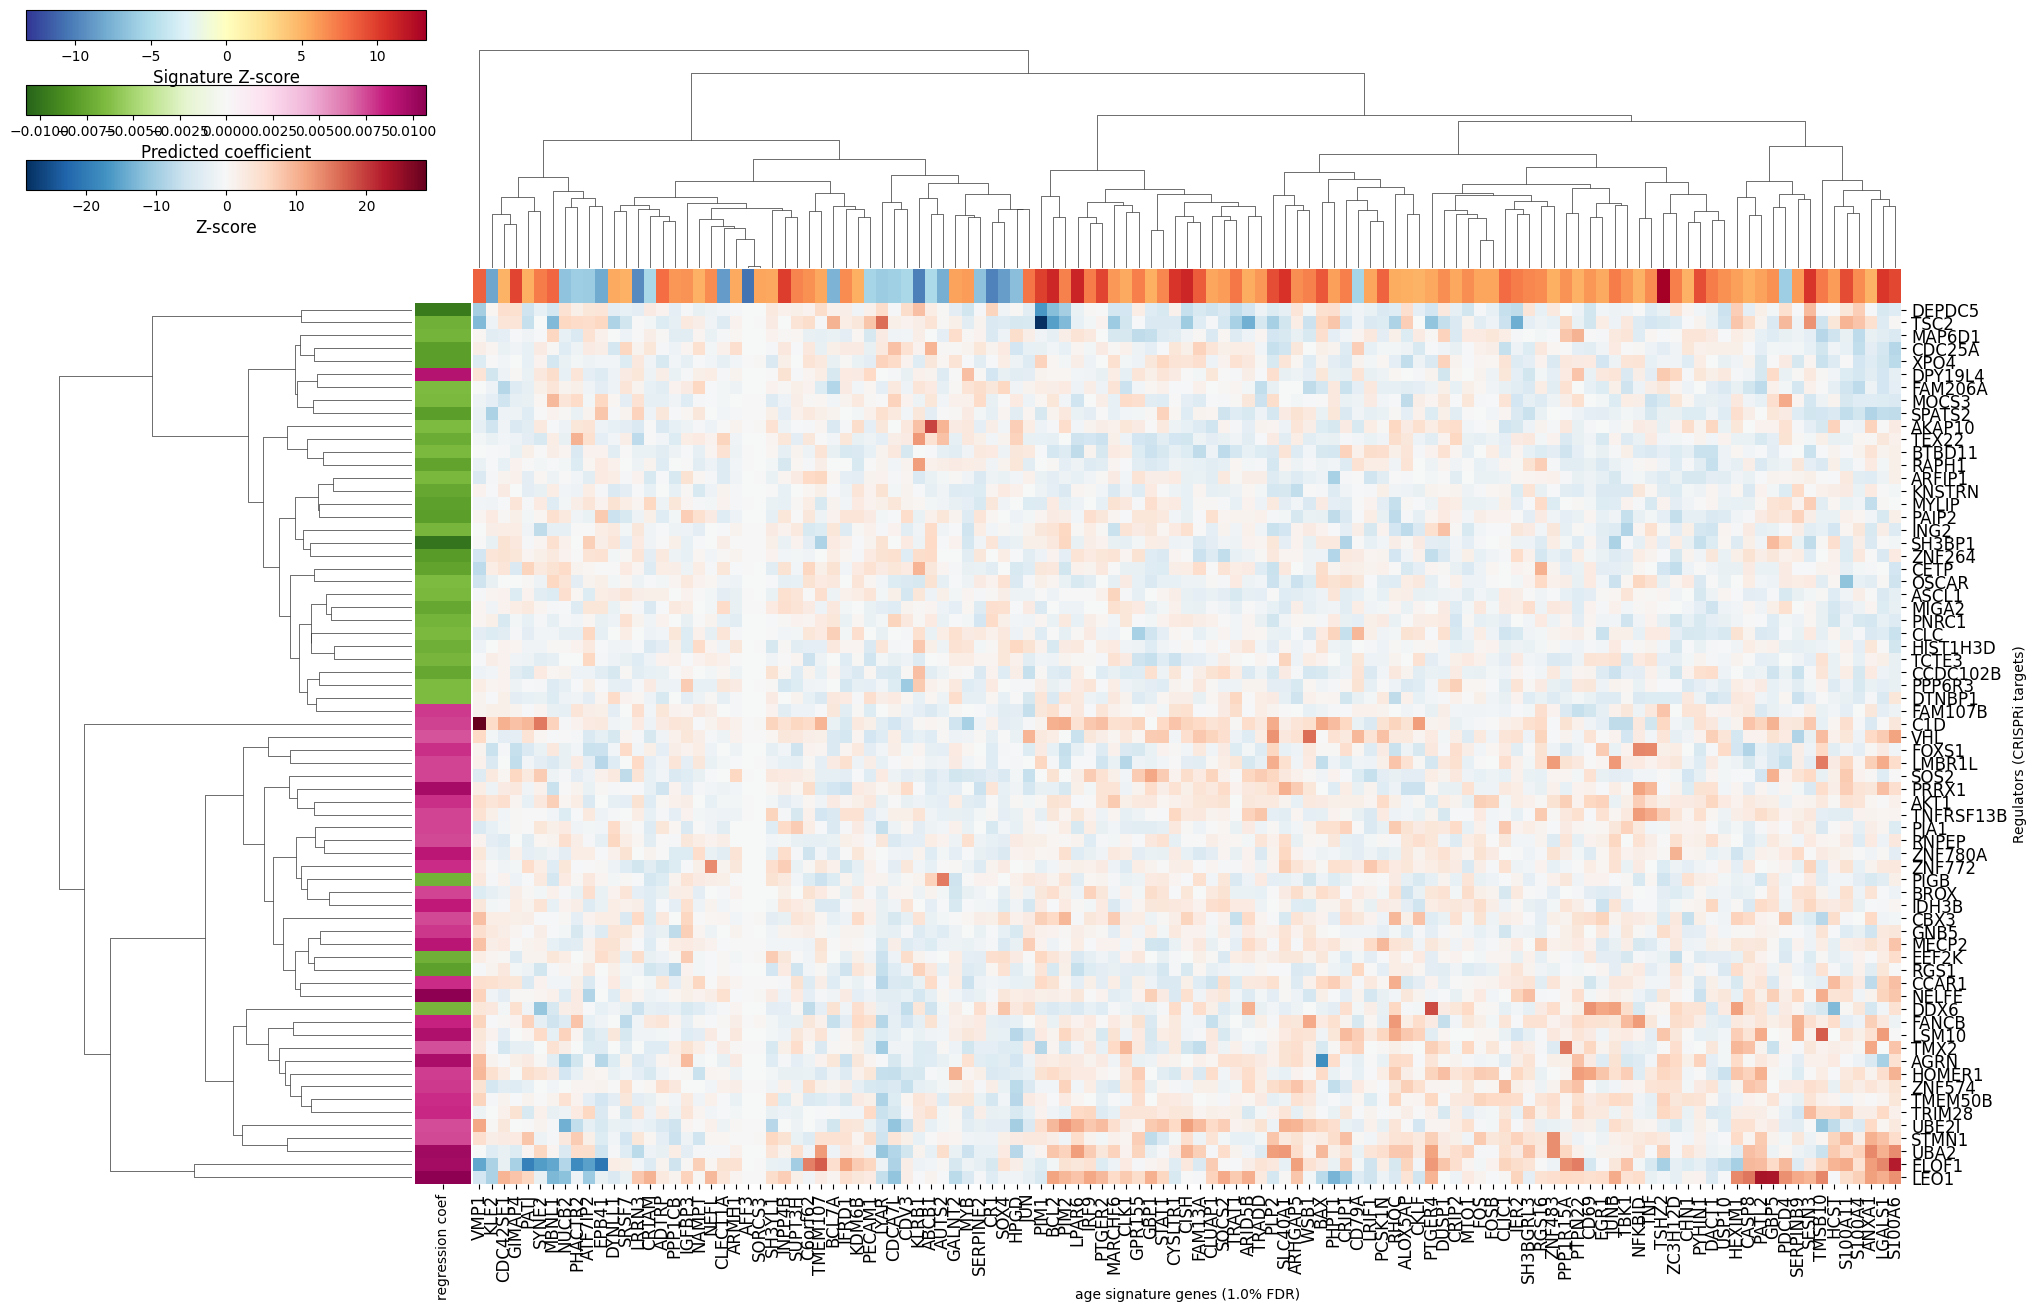

In [200]:
# Create row annotation dataframe with predicted effect sizes (now rows after transpose)
row_annot = pd.DataFrame({
    'regression coef': predicted_effect_size[wide_de_results.index]
})

# Create column annotation dataframe with signature zscores (now columns after transpose)
col_annot = pd.DataFrame({
    'zscore': signature_effect_size.set_index('gene_name').loc[wide_de_results.columns, 'zscore']
})

# Create different color maps for annotations
cmap_row = plt.cm.PiYG_r    # Pink-Yellow-Green for row annotation (predicted effect size)
cmap_col = plt.cm.RdYlBu_r  # Red-Yellow-Blue for column annotation (signature zscore)

# Center the colormaps at 0 by using symmetric vmin/vmax
vmax_row = max(abs(row_annot['regression coef'].min()), abs(row_annot['regression coef'].max()))
vmax_col = max(abs(col_annot['zscore'].min()), abs(col_annot['zscore'].max()))
# Create color series for annotations (seaborn expects Series, not DataFrame with RGBA)
row_colors = row_annot['regression coef'].apply(lambda x: cmap_row((x + vmax_row) / (2 * vmax_row)))
col_colors = col_annot['zscore'].apply(lambda x: cmap_col((x + vmax_col) / (2 * vmax_col)))

# Create the clustermap
plt.figure(figsize=(30, 20))
g = sns.clustermap(wide_de_results,
                   cmap='RdBu_r',
                   center=0,
                   vmin=-10,
                   vmax=10,
                   row_cluster=True,
                   col_cluster=True,
                   xticklabels=True,
                   yticklabels=True,
                   method='ward',
                   figsize=(20, 15),
                   row_colors=row_colors,
                   col_colors=[col_colors],
                   cbar_pos=None)

# Adjust layout to make room for additional colorbars
plt.subplots_adjust(top=0.85)

# Add colorbars for annotations - all same width and height
colorbar_width = 0.2
colorbar_height = 0.02
colorbar_left = 0

# Main heatmap colorbar - bottom
cbar_ax_main = g.fig.add_axes([colorbar_left, 0.75, colorbar_width, colorbar_height])
vmax_main = max(abs(wide_de_results.min().min()), abs(wide_de_results.max().max()))
sm_main = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-vmax_main, vmax=vmax_main))
sm_main.set_array([])
cbar_main = plt.colorbar(sm_main, cax=cbar_ax_main, orientation='horizontal')
cbar_main.set_label('Z-score', fontsize=12)

# Row annotation colorbar (predicted effect size)
cbar_ax_row = g.fig.add_axes([colorbar_left, 0.80, colorbar_width, colorbar_height])
sm_row = plt.cm.ScalarMappable(cmap=cmap_row, norm=plt.Normalize(vmin=-vmax_row, vmax=vmax_row))
sm_row.set_array([])
cbar_row = plt.colorbar(sm_row, cax=cbar_ax_row, orientation='horizontal')
cbar_row.set_label('Predicted coefficient', fontsize=12)

# Column annotation colorbar (signature zscore)
cbar_ax_col = g.fig.add_axes([colorbar_left, 0.85, colorbar_width, colorbar_height])
sm_col = plt.cm.ScalarMappable(cmap=cmap_col, norm=plt.Normalize(vmin=-vmax_col, vmax=vmax_col))
sm_col.set_array([])
cbar_col = plt.colorbar(sm_col, cax=cbar_ax_col, orientation='horizontal')
cbar_col.set_label('Signature Z-score', fontsize=12)

# Rotate x-axis labels
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center', fontsize=12)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=12)

plt.show()

True

---

In [41]:
onek1k_path = '/mnt/oak/users/lillian/data/Yazar2022_full_processed.h5ad'
onek1k_ct_counts = pd.read_csv('/mnt/oak/users/lillian/data/cell_type_counts_full.csv', index_col=0)
pct_lymphocytes = calculate_B_T_pct(onek1k_ct_counts)

In [3]:
h5ad_file = '/mnt/oak/users/emma/data/cxg_datasets/Yazar2022.h5ad'
adata_1k1k = anndata.read_h5ad(h5ad_file, backed=True)

In [13]:
adata_1k1k

AnnData object with n_obs × n_vars = 1248980 × 36571 backed at '/mnt/oak/users/emma/data/cxg_datasets/Yazar2022.h5ad'
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'donor_id', 'pool_number', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'age', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'cell_type_ontology_term_id_colors', 'default_embedding', 'schema_version', 'title', 'orig.ident_colors', 'predicted.celltype.l2_colors'
 

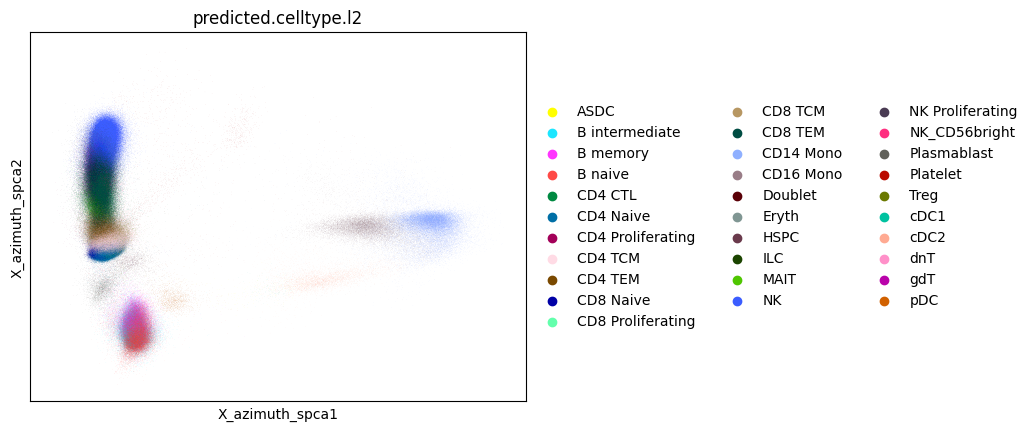

In [16]:
sc.pl.embedding(adata_1k1k, 'X_azimuth_spca', color='predicted.celltype.l2')

In [ ]:
adata_1k1k = anndata.experimental.read_lazy(onek1k_path)
adata = anndata.AnnData(
        obs=adata_1k1k.obs.to_dataframe(),
        var=adata_1k1k.var.to_dataframe()
    )
# adata.layers['counts'] = adata_1k1k.layers['counts']
adata.X = adata_1k1k.layers['counts']
adata

AnnData object with n_obs × n_vars = 526798 × 36571
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'donor_id', 'pool_number', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'age', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.v

### Feature selection

In [53]:
# adata = adata[:, (adata.var['n_cells_by_counts'] > 0)].copy()
# # adata = adata[:, (adata.var['n_cells_by_counts'] > 10) & (adata.var['n_cells_by_counts'] < 500000)].copy()
# # adata = adata[:, (adata.var['n_cells_by_counts'] < 500000)].copy()

# adata.var['highly_variable'] = adata.var_names.isin(adata.var['dispersions_norm'].nlargest(10000).index)

# # get features used on perturb-seq dataset
adata_de_var = sc.read_h5ad(f'/mnt/oak/users/emma/data/GWT/CD4i_final//DE_results_all_confounders/CD4i_final.merged_DE_results.h5ad').var
#  adata = adata[:, adata.var_names.isin(adata_de_var['gene_ids'])].copy()

In [1410]:
adata = adata[adata.obs['predicted.celltype.l2'] == 'CD4 TCM'].copy()

In [1411]:
# adata = adata[:, adata.var['highly_variable']].to_memory()
adata = adata.to_memory()

In [2]:
import os
os.listdir()

['compare.py',
 '1k1k_analysis.py',
 '1k1k_highly_variable_5000_genes.csv',
 'pbulked.h5ad',
 'results',
 'process.py',
 'plot.py',
 '1k1k_DE_analysis.ipynb']

In [497]:
# sc.pl.highly_variable_genes(adata)

## Pseudobulk

In [1413]:
pbulk_cols = ['donor_id']
n_cells = adata.obs.groupby(pbulk_cols).size().reset_index().rename({0:'n_cells'}, axis=1)

# Get total cells per donor and filter for >100 cells
donor_total_cells = n_cells.groupby('donor_id')['n_cells'].sum()
# Filter donors between 10th and 90th percentiles of total cells
lower_quantile = donor_total_cells.quantile(0.1)
upper_quantile = donor_total_cells.quantile(0.99)
valid_donors = donor_total_cells[(donor_total_cells >= lower_quantile) & (donor_total_cells <= upper_quantile)].index

# Filter adata for valid donors before aggregating
adata_filtered = adata[adata.obs['donor_id'].isin(valid_donors)].copy()

donor_metadata_cols = ['donor_id', 'pool_number', 'age', 'sex']
donor_metadata = adata_filtered.obs[donor_metadata_cols].drop_duplicates().set_index('donor_id')
donor_metadata['age_cat'] = donor_metadata["age"].apply(categorize_age)
pbulk_adata = sc.get.aggregate(adata_filtered, by=pbulk_cols, func=['sum'])

pbulk_adata.X = pbulk_adata.layers['sum'].copy()
# Add lymphocyte percentages and donor metadata
pbulk_adata.obs = pd.merge(pbulk_adata.obs, pct_lymphocytes, how='left')
pbulk_adata.obs = pd.merge(pbulk_adata.obs, donor_metadata.reset_index(), on='donor_id', how='left')
pbulk_adata.obs = pd.merge(pbulk_adata.obs, n_cells, how='left')
pbulk_adata.obs['log10_n_cells'] = np.log10(pbulk_adata.obs['n_cells'])
# Calculate total counts per donor
pbulk_adata.obs['total_counts'] = pbulk_adata.X.sum(axis=1)

# pbulk_adata.obs['cell_type'] = pbulk_adata.obs['predicted.celltype.l2']
# pbulk_adata = pbulk_adata[pbulk_adata.obs['cell_type'] != 'CD4 TEM'].copy()

pbulk_adata

/tmp/ipykernel_2345666/539000245.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  n_cells = adata.obs.groupby(pbulk_cols).size().reset_index().rename({0:'n_cells'}, axis=1)
/tmp/ipykernel_2345666/539000245.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  donor_total_cells = n_cells.groupby('donor_id')['n_cells'].sum()


AnnData object with n_obs × n_vars = 876 × 29184
    obs: 'donor_id', 'percent_B_cells', 'percent_T_cells', 'pool_number', 'age', 'sex', 'age_cat', 'n_cells', 'log10_n_cells', 'total_counts'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'sum'

In [55]:
pbulk_adata = sc.read_h5ad('pbulked.h5ad')
pbulk_adata.var_names.isin(adata_de_var.index).sum()

3450

In [7]:
plt.figure(figsize=(10,6))
plt.scatter(pbulk_adata.obs['log10_n_cells'], pbulk_adata.obs['total_counts'], alpha=0.5)
plt.xlabel('log10(Number of cells)')
plt.ylabel('Total counts')
plt.title('Total counts vs Number of cells per donor')


KeyError: 'log10_n_cells'

<Figure size 1000x600 with 0 Axes>

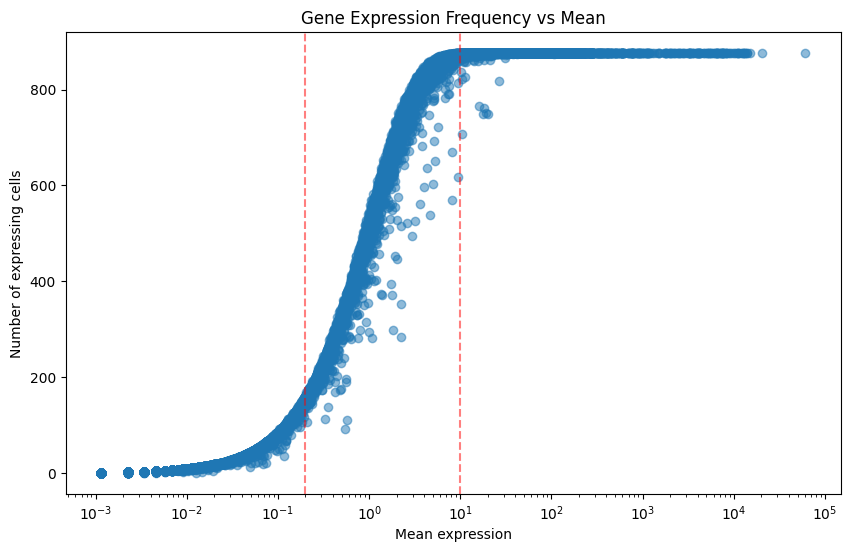

In [1415]:
# Find genes that are expressed in all samples
n_samples = pbulk_adata.n_obs
df = pd.DataFrame({
    'counts': (pbulk_adata.X > 0).sum(axis=0),
    'means': pbulk_adata.X.mean(axis=0)
}, index=pbulk_adata.var_names)

# Plot relationship between mean expression and number of expressing cells
plt.figure(figsize=(10,6))
plt.scatter(df['means'], df['counts'], alpha=0.5)
plt.xlabel('Mean expression')
plt.ylabel('Number of expressing cells')
# plt.yscale("log")
plt.xscale("log")
plt.title('Gene Expression Frequency vs Mean')
plt.axvline(x=0.2, color='r', linestyle='--', alpha=0.5)
plt.axvline(x=10, color='r', linestyle='--', alpha=0.5)

In [1416]:
# Find genes that are expressed in all samples
n_samples = pbulk_adata.n_obs
gene_counts = (pbulk_adata.X > 0).sum(axis=0)
gene_means = pbulk_adata.X.mean(axis=0)
genes_2_keep = pbulk_adata.var_names[(gene_means < 10) & (gene_means > 0.2)]

# Exclude ubiquitously expressed
pbulk_adata = pbulk_adata[:, genes_2_keep].copy()
pbulk_adata

AnnData object with n_obs × n_vars = 876 × 9464
    obs: 'donor_id', 'percent_B_cells', 'percent_T_cells', 'pool_number', 'age', 'sex', 'age_cat', 'n_cells', 'log10_n_cells', 'total_counts'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'sum'

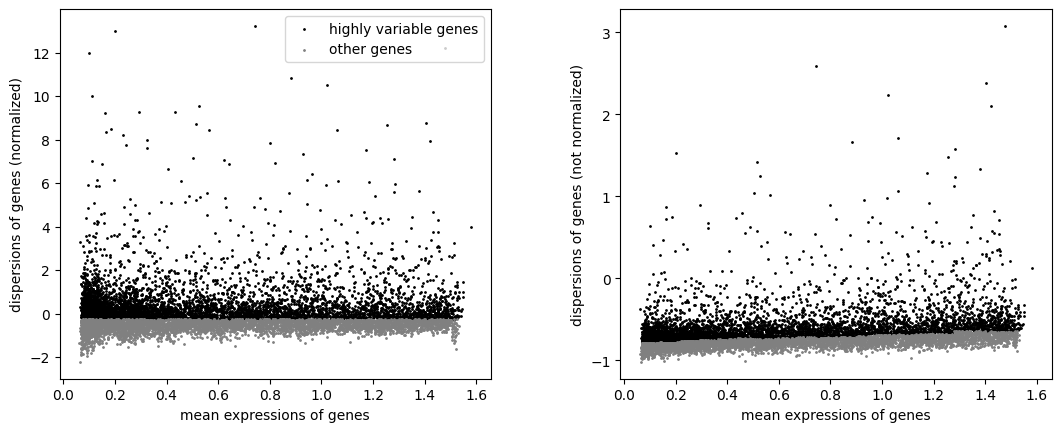

In [1417]:
scales_counts = sc.pp.normalize_total(pbulk_adata, target_sum=10000, inplace=False)
pbulk_adata.X = sc.pp.log1p(scales_counts["X"], copy=True)
sc.pp.highly_variable_genes(pbulk_adata, n_top_genes=5000)
sc.pl.highly_variable_genes(pbulk_adata)
pbulk_adata.X = pbulk_adata.layers['sum']

# n_samples = pbulk_adata.n_obs
# df = pd.DataFrame({
#     'counts': (pbulk_adata.X > 0).sum(axis=0),
#     'means': pbulk_adata.X.mean(axis=0)
# }, index=pbulk_adata.var_names)

# # Plot relationship between mean expression and number of expressing cells
# plt.figure(figsize=(10,6))
# plt.scatter(df['means'], df['counts'], alpha=0.5)
# plt.xlabel('Mean expression')
# plt.ylabel('Number of expressing cells')
# # plt.yscale("log")
# plt.xscale("log")
# plt.title('Gene Expression Frequency vs Mean')
# plt.axvline(x=0.1, color='r', linestyle='--', alpha=0.5)
# plt.axvline(x=11, color='r', linestyle='--', alpha=0.5)

In [1418]:
# pbulk_adata_pca = pbulk_adata[pbulk_adata.obs['predicted.celltype.l2'] == 'CD4 Naive'].copy()
pbulk_adata_pca = pbulk_adata.copy()
pbulk_adata_pca.obs_names = pbulk_adata_pca.obs['donor_id'].values
scales_counts = sc.pp.normalize_total(pbulk_adata_pca, target_sum=None, inplace=False)
pbulk_adata_pca.X = sc.pp.log1p(scales_counts["X"], copy=True)
sc.pp.pca(pbulk_adata_pca) 

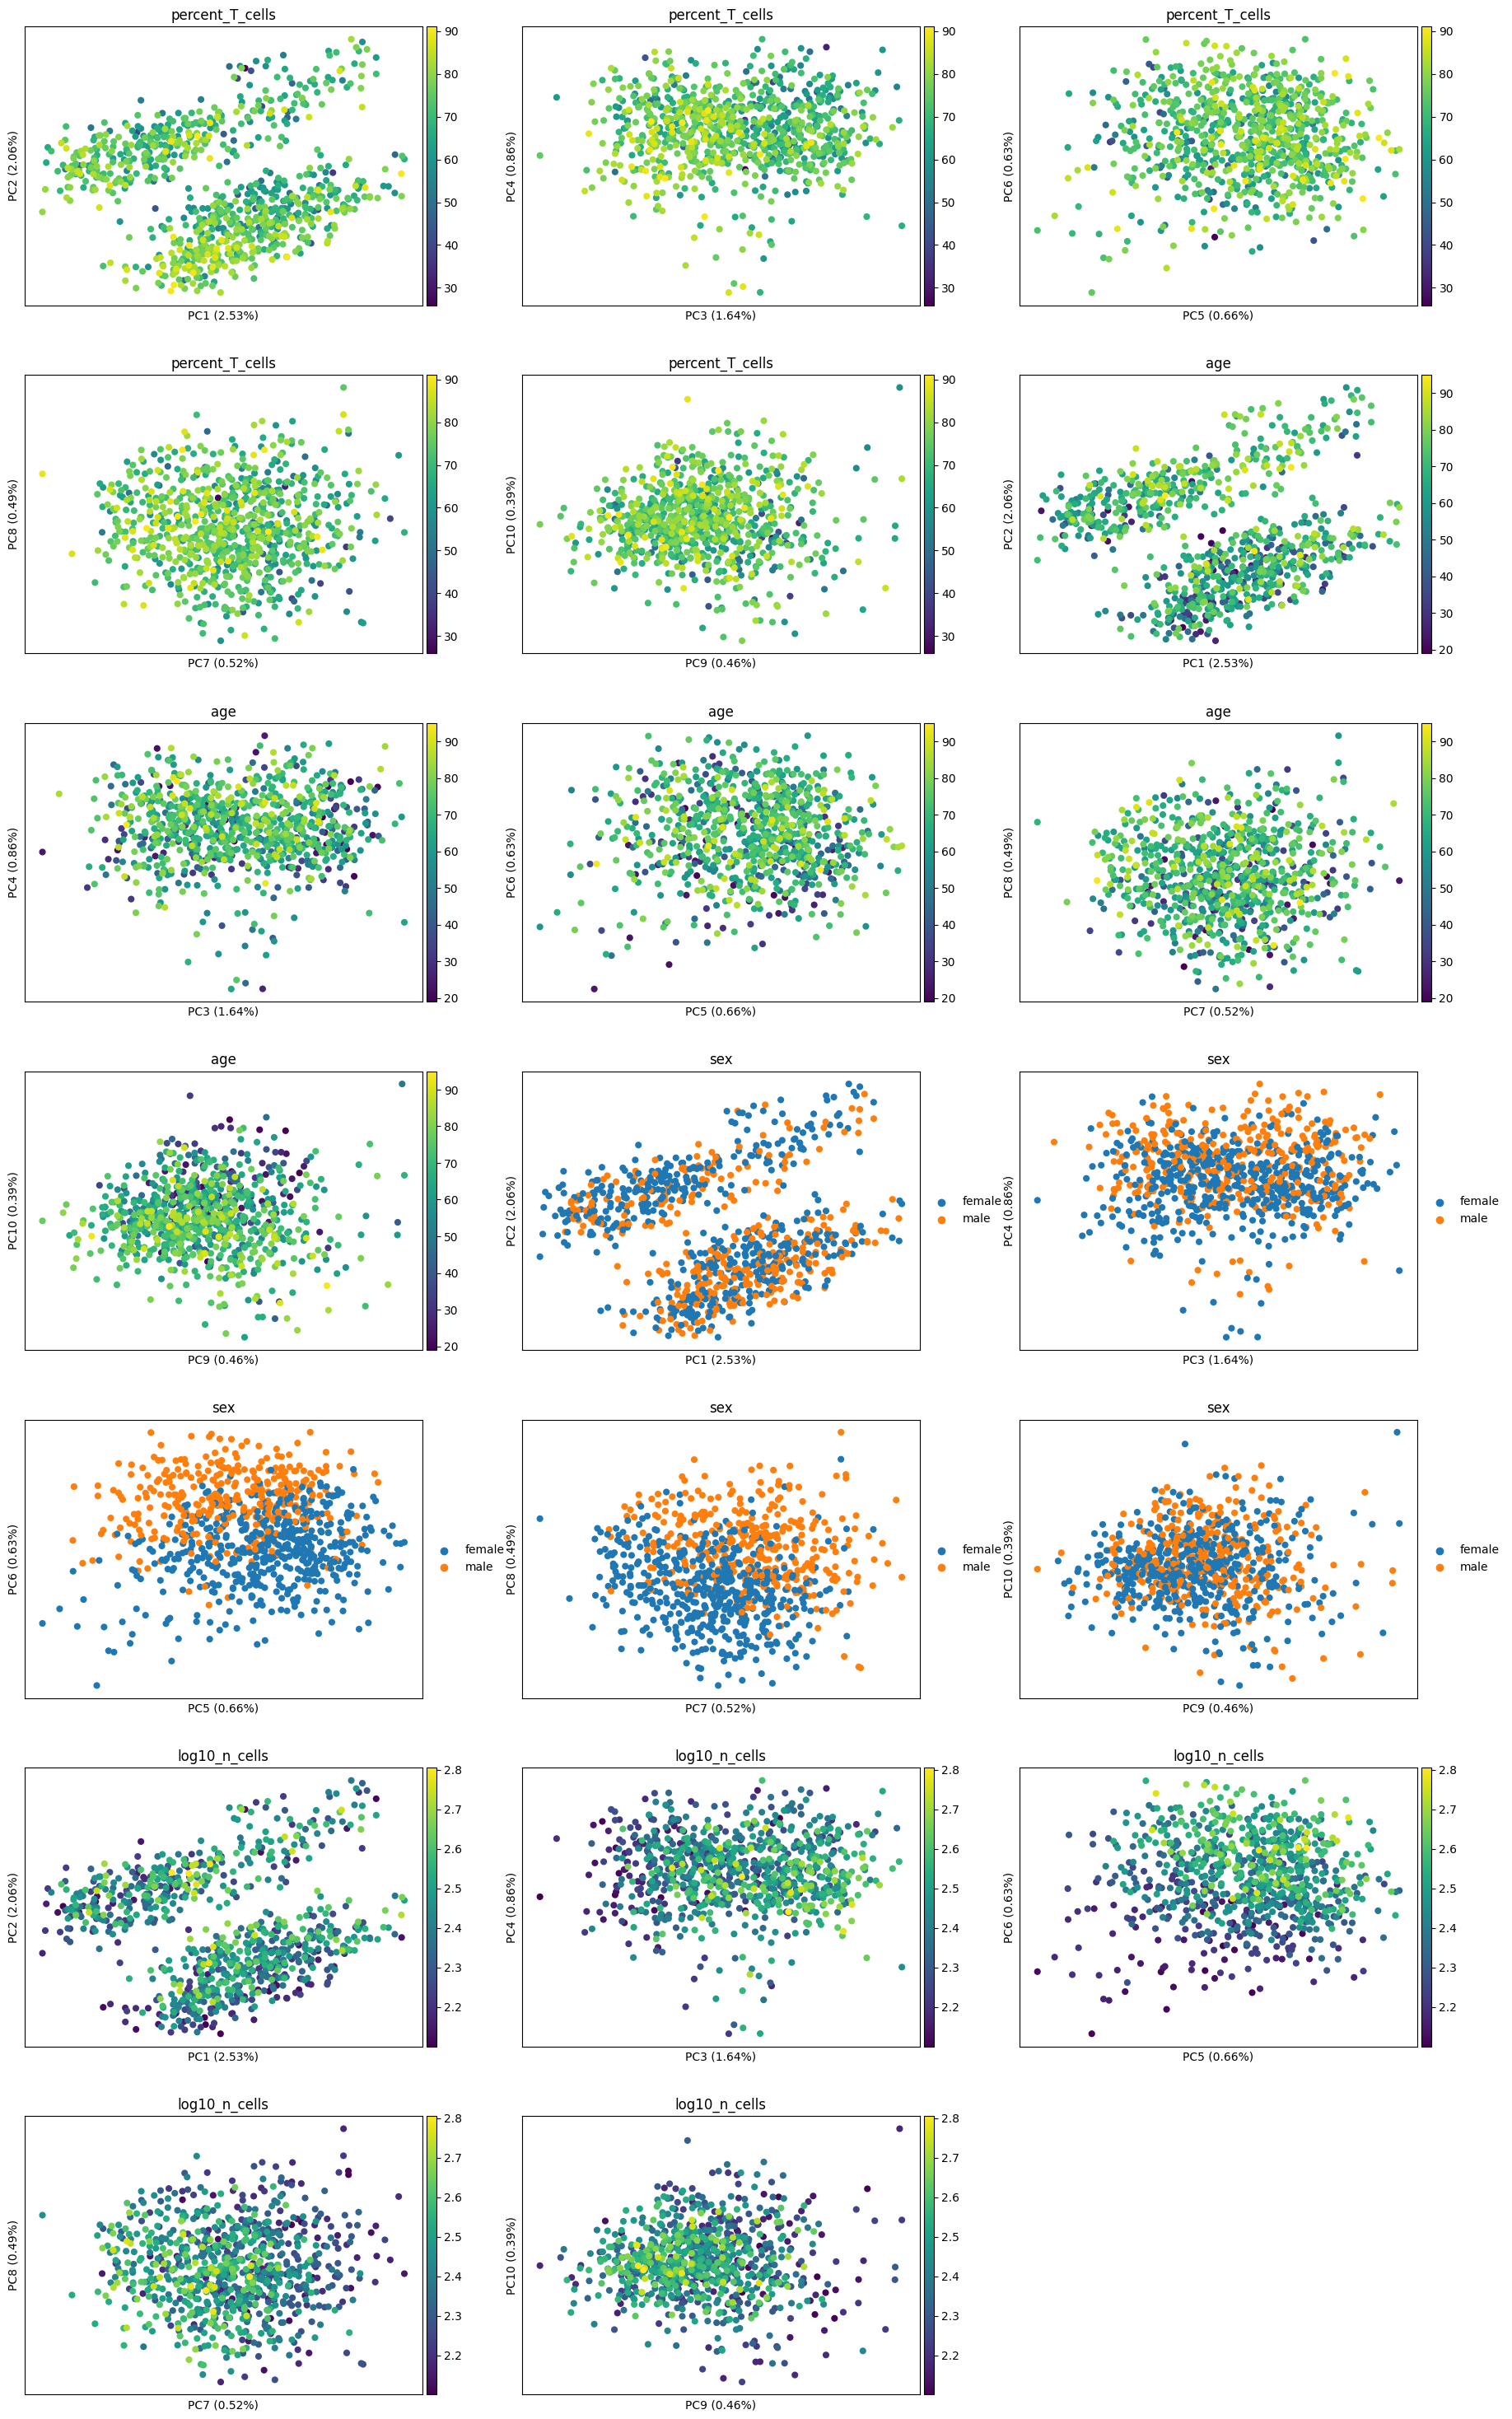

/tmp/ipykernel_2345666/391751638.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pool_means = df.groupby('pool_number')['PC1'].mean().sort_values()


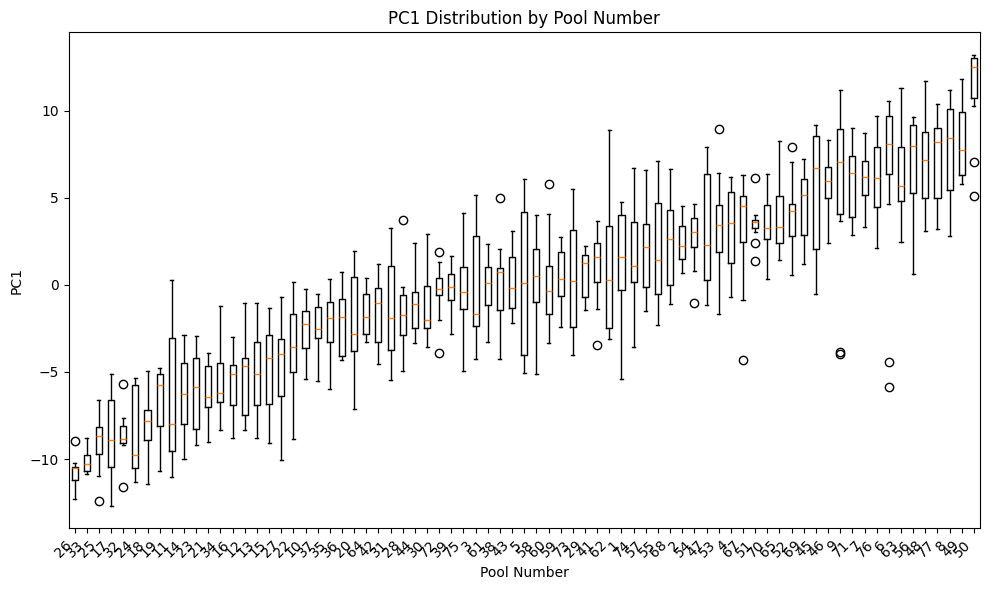

In [1419]:
sc.pl.pca(pbulk_adata_pca, color=['percent_T_cells', 'age', 'sex', 'log10_n_cells'], components=['1,2', '3,4', '5,6', '7,8', '9,10'], ncols=3, annotate_var_explained=True)

# Plot PC1 vs pool
df = pd.DataFrame({
    'pool_number': pbulk_adata_pca.obs['pool_number'],
    'PC1': pbulk_adata_pca.obsm['X_pca'][:,0]
})

pool_means = df.groupby('pool_number')['PC1'].mean().sort_values()
sorted_pools = pool_means.index

plt.figure(figsize=(10,6))
plt.boxplot([df[df['pool_number']==pool]['PC1'] for pool in sorted_pools], 
            labels=sorted_pools)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Pool Number')
plt.ylabel('PC1')
plt.title('PC1 Distribution by Pool Number')
plt.tight_layout()

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['RP11-34P13.13', 'LINC01409', 'LINC01128', 'LINC00115', 'FAM41C']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


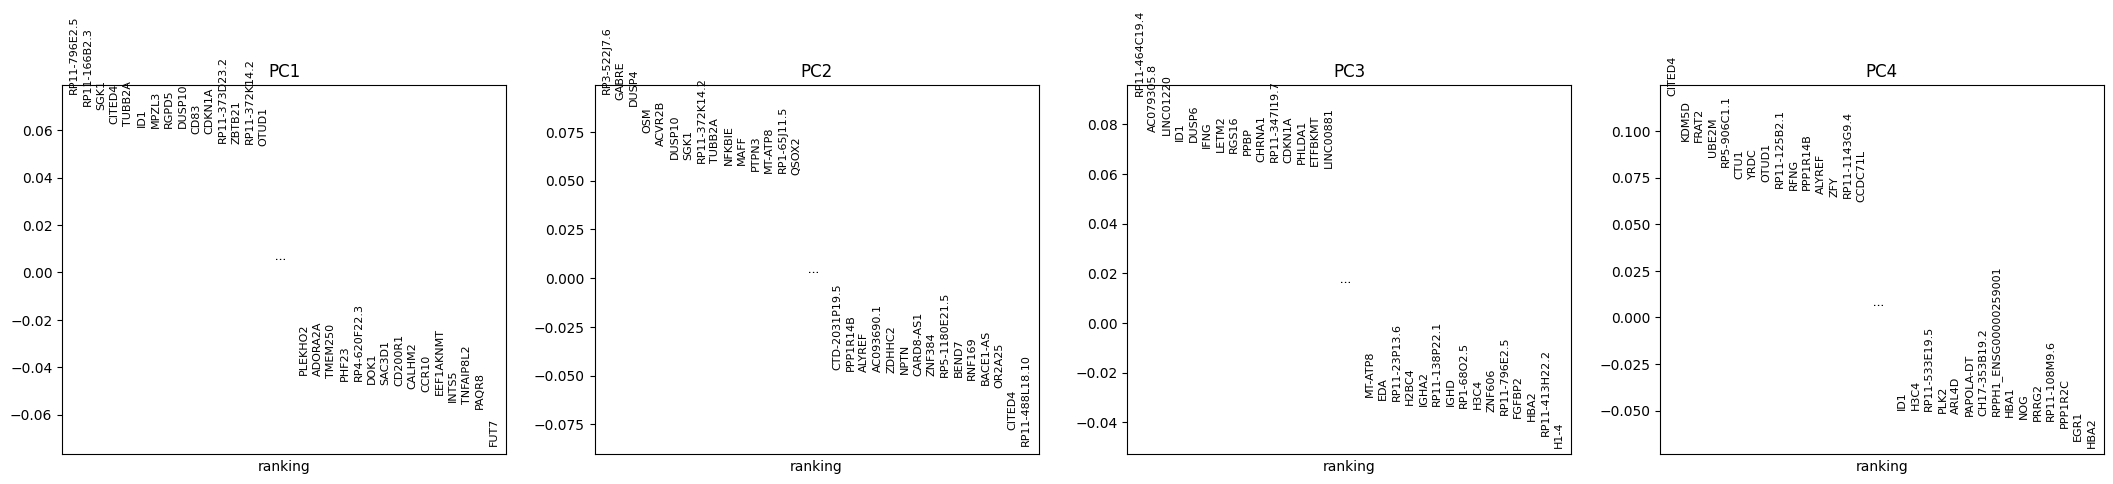

In [1420]:
pbulk_adata_pca.var_names = pbulk_adata_pca.var['feature_name'].copy()
sc.pl.pca_loadings(pbulk_adata_pca,[1,2,3,4])

In [1421]:
top_pcs = sc.get.obs_df(pbulk_adata_pca, obsm_keys=[('X_pca', i) for i in range(20)]).reset_index()
top_pcs.columns = ['donor_id'] + [f'donor_PC{i+1}' for i in range(20)]

In [1422]:
pbulk_adata.obs = pd.merge(pbulk_adata.obs, top_pcs)


In [1423]:
pbulk_adata

AnnData object with n_obs × n_vars = 876 × 9464
    obs: 'donor_id', 'percent_B_cells', 'percent_T_cells', 'pool_number', 'age', 'sex', 'age_cat', 'n_cells', 'log10_n_cells', 'total_counts', 'donor_PC1', 'donor_PC2', 'donor_PC3', 'donor_PC4', 'donor_PC5', 'donor_PC6', 'donor_PC7', 'donor_PC8', 'donor_PC9', 'donor_PC10', 'donor_PC11', 'donor_PC12', 'donor_PC13', 'donor_PC14', 'donor_PC15', 'donor_PC16', 'donor_PC17', 'donor_PC18', 'donor_PC19', 'donor_PC20'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    layers: 'sum'

## DE test


In [18]:
metadata = pbulk_adata.obs.copy()
metadata = metadata.loc[:,~metadata.columns.str.startswith('pool')]
covars = list(metadata.columns.drop(['age','donor_id','predicted.celltype.l2','total_counts','cell_counts','avg_count_per_cell','log_counts_per_cell']))
covars

['male',
 'CD4_Naive',
 'CD4_TCM',
 'age_cat',
 'percent_B_cells',
 'percent_T_cells']

In [ ]:
pbulk_adata.var_names = pbulk_adata.var['feature_name']

feature_name  _normed_means  non_zero  _MoM_dispersions  \
ensembl_id                                                                  
ENSG00000241180    RP11-54O7.2       0.000105      True      1.000000e-08   
ENSG00000187608          ISG15      24.951201      True      1.800509e-01   
ENSG00000285812  RP11-465B22.9       0.019745      True      1.000000e-08   
ENSG00000223823      LINC01342       0.001069      True      1.000000e-08   
ENSG00000186827        TNFRSF4       7.660033      True      4.148061e-01   
...                        ...            ...       ...               ...   
ENSG00000169807           PRY2       0.000189      True      1.000000e-08   
ENSG00000228786   LINC00266-4P       0.002916      True      1.000000e-08   
ENSG00000198763         MT-ND2    1037.818202      True      5.548903e-02   
ENSG00000198804         MT-CO1    1377.589436      True      2.377182e-02   
ENSG00000198938         MT-CO3    1110.508826      True      2.300542e-02   

                 genewise_dispersions _genewise_converged  fitted_dispersions  \
ensembl_id                                                                      
ENSG00000241180          1.000000e-08                True        19523.742396   
ENSG00000187608          1.020393e-01                True            0.133332   
ENSG00000285812          1.000000e-08                True          103.664228   
ENSG00000223823          1.000000e-08                True         1914.474616   
ENSG00000186827          1.005419e-01                True            0.318420   
...                               ...                 ...                 ...   
ENSG00000169807          1.000000e-08                True        10838.013842   
ENSG00000228786          1.000000e-08                True          701.662185   
ENSG00000198763          4.510269e-02                True            0.053308   
ENSG00000198804          2.264312e-02                True            0.052822   
ENSG00000198938          2.214523e-02                True            0.053179   

                 MAP_dispersions _MAP_converged  dispersions  _outlier_genes  \
ensembl_id                                                                     
ENSG00000241180      2943.000000           True  2943.000000           False   
ENSG00000187608         0.102059           True     0.102059           False   
ENSG00000285812        61.729636           True    61.729636           False   
ENSG00000223823      1915.557906           True  1915.557906           False   
ENSG00000186827         0.100734           True     0.100734           False   
...                          ...            ...          ...             ...   
ENSG00000169807      2943.000000           True  2943.000000           False   
ENSG00000228786       818.512364           True   818.512364           False   
ENSG00000198763         0.045106           True     0.045106           False   
ENSG00000198804         0.022651           True     0.022651           False   
ENSG00000198938         0.022153           True     0.022153           False   

                _LFC_converged  replaced  refitted  _pvalue_cooks_outlier  
ensembl_id                                                                 
ENSG00000241180           True     False     False                  False  
ENSG00000187608           True     False     False                  False  
ENSG00000285812           True     False     False                  False  
ENSG00000223823           True     False     False                  False  
ENSG00000186827           True     False     False                  False  
...                        ...       ...       ...                    ...  
ENSG00000169807           True     False     False                  False  
ENSG00000228786           True     False     False                  False  
ENSG00000198763           True     False     False                  False  
ENSG00000198804           True     False     False                  False  
ENSG00000

In [20]:
onek1k_design = f"~ male + age_cat + percent_B_cells + percent_T_cells + CD4_TCM + CD4_Naive"
print(onek1k_design)
# pbulk_adata.X = pbulk_adata.layers['sum'].copy()
# pbulk_adata.var = pbulk_adata.var.reset_index()
# pbulk_adata.var.index = pbulk_adata.var['feature_name'].values
model = pertpy.tl.PyDESeq2(pbulk_adata, design=onek1k_design)
model.fit(quiet=True)

~ male + age_cat + percent_B_cells + percent_T_cells + CD4_TCM + CD4_Naive


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done 717 tasks      | elapsed:    2.9s
[Parallel(n_jobs=64)]: Done 2382 tasks      | elapsed:    3.3s
[Parallel(n_jobs=64)]: Done 5000 out of 5000 | elapsed:    3.8s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 2382 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 5000 out of 5000 | elapsed:    0.8s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 2382 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 5000 out of 5000 | elapsed:    0.9s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 2382 tas

In [24]:
covar = 'male'

contrast = np.zeros(len(model.dds.obsm['design_matrix'].columns), dtype=int)
contrast[np.where(model.dds.obsm['design_matrix'].columns == covar)[0][0]] = 1
res_df = model.test_contrasts(contrast)

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [0 1 0 0 0 0 0]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ensembl_id                                                                   
ENSG00000241180     0.000105        0.207943  2.991035  0.069522  0.944574   
ENSG00000187608    24.951201       -0.044697  0.021528 -2.076198  0.037876   
ENSG00000285812     0.019745        0.213657  0.453790  0.470828  0.637764   
ENSG00000223823     0.001069        0.206931  2.414673  0.085697  0.931707   
ENSG00000186827     7.660033        0.068784  0.027988  2.457607  0.013987   
...                      ...             ...       ...       ...       ...   
ENSG00000169807     0.000189        0.208356  2.991034  0.069660  0.944464   
ENSG00000228786     0.002916        0.194648  1.582329  0.123014  0.902096   
ENSG00000198763  1037.818202       -0.038283  0.011981 -3.195438  0.001396   
ENSG00000198804  1377.589436        0.037570  0.008574  4.381733  0.000

... done in 0.68 seconds.



In [56]:
res_df = pd.read_csv('results/DE_age_cat.csv')
res_df = res_df.rename({'log2FoldChange':'log_fc', 'padj':'adj_p_value', 'ensembl_id':'variable'}, axis=1)
res_df

variable     baseMean    log_fc     lfcSE      stat    pvalue  \
0     ENSG00000241180     0.000105  0.008661  1.346779  0.006431  0.994869   
1     ENSG00000187608    24.951201 -0.013711  0.009435 -1.453144  0.146184   
2     ENSG00000285812     0.019745  0.007370  0.208147  0.035409  0.971753   
3     ENSG00000223823     0.001069  0.005589  1.346768  0.004150  0.996689   
4     ENSG00000186827     7.660033 -0.014927  0.012010 -1.242814  0.213936   
...               ...          ...       ...       ...       ...       ...   
4995  ENSG00000169807     0.000189  0.008843  1.346779  0.006566  0.994761   
4996  ENSG00000228786     0.002916  0.009977  0.802468  0.012432  0.990081   
4997  ENSG00000198763  1037.818202  0.016702  0.005199  3.212401  0.001316   
4998  ENSG00000198804  1377.589436 -0.008438  0.003556 -2.372830  0.017652   
4999  ENSG00000198938  1110.508826 -0.012045  0.003744 -3.217615  0.001293   

      adj_p_value  
0             NaN  
1        0.462435  
2             NaN  
3             NaN  
4        0.587697  
...           ...  
4995          NaN  
4996          NaN  
4997     0.011921  
4998     0.095766  
4999     0.011852  

[5000 rows x 7 columns]

In [1424]:
onek1k_design = f"~ log10_n_cells + percent_T_cells + {' + '.join([f'donor_PC{i}' for i in range(1,10)])} + age_cat + sex"
print(onek1k_design)
pbulk_adata.X = pbulk_adata.layers['sum'].copy()
pbulk_adata.var = pbulk_adata.var.reset_index()
pbulk_adata.var.index = pbulk_adata.var['feature_name'].values
model = pertpy.tl.PyDESeq2(pbulk_adata, design=onek1k_design)
model.fit(quiet=True)

~ log10_n_cells + percent_T_cells + donor_PC1 + donor_PC2 + donor_PC3 + donor_PC4 + donor_PC5 + donor_PC6 + donor_PC7 + donor_PC8 + donor_PC9 + age_cat + sex


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   2 out of   2 | elapsed:   37.7s finished
[Parallel(n_jobs=64)]: Done 5408 tasks      | elapsed:   39.4s
[Parallel(n_jobs=64)]: Done 8579 tasks      | elapsed:   39.7s
[Parallel(n_jobs=64)]: Done 8929 tasks      | elapsed:   40.0s
[Parallel(n_jobs=64)]: Done 9379 tasks      | elapsed:   40.4s
[Parallel(n_jobs=64)]: Done 9464 out of 9464 | elapsed:   40.5s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done 4264 tasks      | elapsed:    0.8s
[Parallel(n_jobs=64)]: Done 7308 tasks      | elapsed:    1.0s
[Parallel(n_jobs=64)]: Done 8928 tasks      | elapsed:    1.2s
[Parallel(n_jobs=64)]: Done 9378 tasks      | elapsed:    1.5s
[Parallel(n_jobs=64)]: Done 9464 out of 9464 | elapsed:    1.5s finished
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/dds.py:784: FutureWarning: Setting an item o

In [1425]:
# Define tests of interest
all_contrasts = {}

all_contrasts['sex'] = model.cond(sex = 'male') 

age_contrast = all_contrasts['sex'].copy()
age_contrast.loc['sex[T.male]'] = 0
age_contrast.loc['age_cat'] = 1
all_contrasts['age'] = age_contrast

pctT_contrast = age_contrast.copy()
pctT_contrast['age_cat'] = 0
pctT_contrast['percent_T_cells'] = 1
all_contrasts['percent_T_cells'] = pctT_contrast


In [1426]:
res_df = model.test_contrasts(all_contrasts)

Running Wald tests...
... done in 1.03 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
RP11-34P13.13  0.294275       -2.989051  2.683571 -1.113834  0.265351   
LINC01409      5.102803        3.400245  0.817493  4.159359  0.000032   
LINC01128      5.238415        2.833207  0.738288  3.837537  0.000124   
LINC00115      1.186887        1.582587  1.536730  1.029841  0.303085   
FAM41C         3.879874        2.855798  0.845663  3.376993  0.000733   
...                 ...             ...       ...       ...       ...   
TTTY14         0.678147        3.421828  2.054382  1.665624  0.095788   
RP11-424G14.1  0.236208        1.800463  2.916763  0.617281  0.537049   
KDM5D          7.149554        2.471589  0.838404  2.947968  0.003199   
TTTY10         0.530114        3.269428  2.189214  1.493426  0.135326   
MT-ATP8        6.906958        0.765702  0.738163  1.037307  0.299593   

                   padj 

... done in 1.04 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
RP11-34P13.13  0.294275       -2.972103  2.672860 -1.111956  0.266157   
LINC01409      5.102803        3.342056  0.814318  4.104118  0.000041   
LINC01128      5.238415        2.654764  0.736578  3.604186  0.000313   
LINC00115      1.186887        1.288539  1.531340  0.841445  0.400099   
FAM41C         3.879874        3.263351  0.843238  3.870023  0.000109   
...                 ...             ...       ...       ...       ...   
TTTY14         0.678147        1.300795  2.035539  0.639042  0.522795   
RP11-424G14.1  0.236208        0.333263  2.890051  0.115314  0.908196   
KDM5D          7.149554       -0.141259  0.832035 -0.169776  0.865187   
TTTY10         0.530114        1.437538  2.167773  0.663141  0.507241   
MT-ATP8        6.906958        0.920552  0.735188  1.252132  0.210522   

                   padj 

... done in 0.99 seconds.



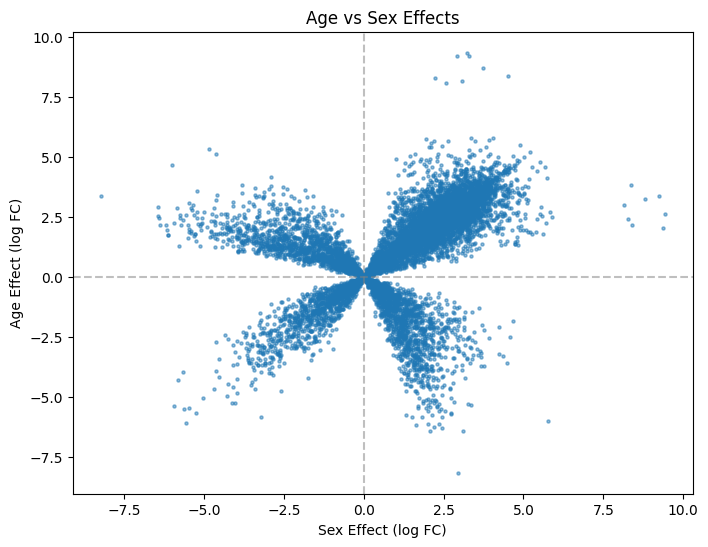

In [1432]:
age_res = res_df[res_df['contrast'] == 'age'].set_index('variable')
sex_res = res_df[res_df['contrast'] == 'percent_T_cells'].set_index('variable')

plt.figure(figsize=(8,6))
plt.scatter(sex_res['log_fc'], age_res['log_fc'], alpha=0.5, s=5)
plt.xlabel('Sex Effect (log FC)')
plt.ylabel('Age Effect (log FC)') 
plt.title('Age vs Sex Effects')
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.show()

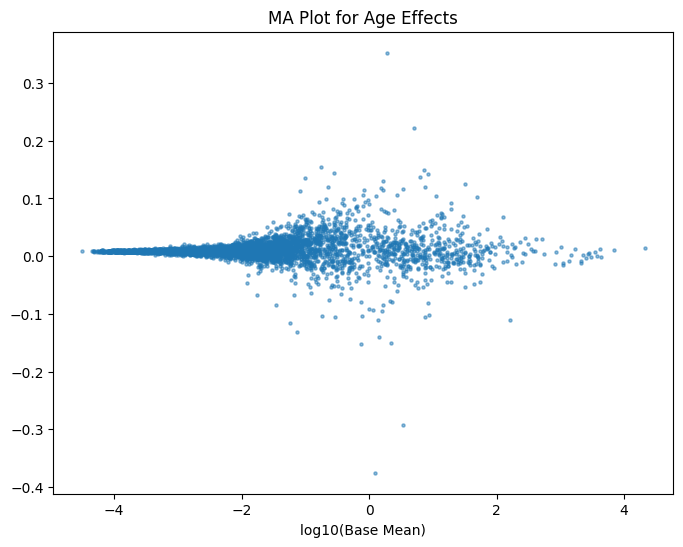

In [57]:
age_res = res_df
# age_res = res_df[res_df['contrast'] == 'male']
# age_res = age_res[age_res['baseMean'] > 1]
plt.figure(figsize=(8,6))
# plt.scatter(np.log10(age_res['baseMean']), -np.log10(age_res['adj_p_value']), alpha=0.5, s=5)
plt.scatter(np.log10(age_res['baseMean']), age_res['log_fc'], alpha=0.5, s=5)
plt.xlabel('log10(Base Mean)')
plt.title('MA Plot for Age Effects')
plt.show()

NaNs encountered, dropping rows with NaNs


<Figure size 1000x3000 with 0 Axes>

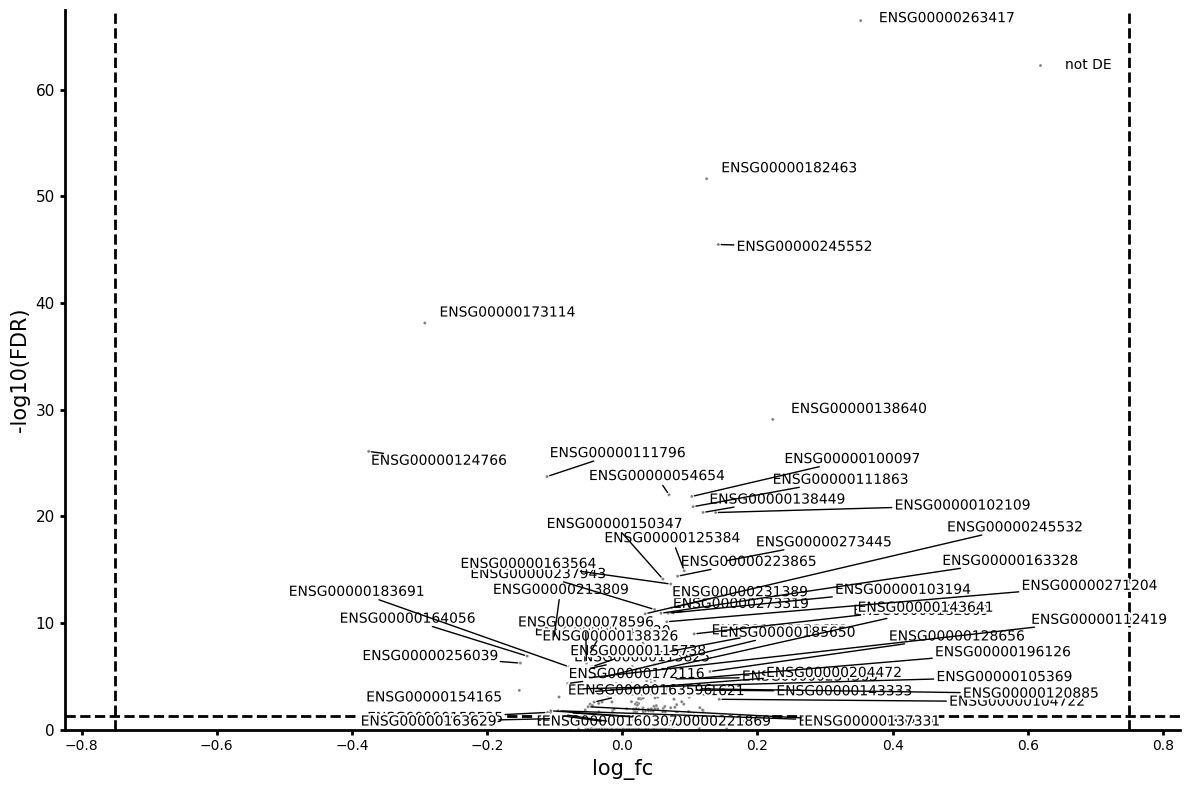

In [58]:
plt.figure(figsize=(10,30))
fig = model.plot_volcano(
    res_df, 
    # log2fc_thresh=4, 
    return_fig=True, 
    to_label = 30,
    # to_label = annotate_gs + top_gs,
    varm_key='ensembl_id',
    figsize=(12, 8),  # Increased figure size
    s=5,
    legend_pos = (0.95,0.95),
    # x_label = f'DE log Fold Change (Th0 vs {p})',
    y_label = '-log10(FDR)'
    )
fig.tight_layout()  # Ensure title is visible
fig.show()  # Explicitly show the figure

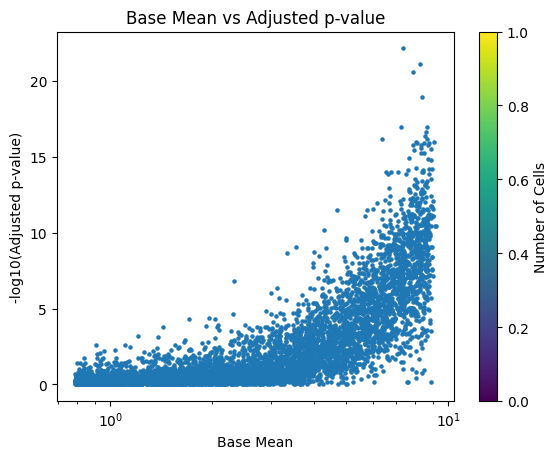

In [1366]:
df = pd.concat([age_res.set_index('variable'), adata.var['n_cells_by_counts']], axis=1)
plt.figure()
plt.scatter(df['baseMean'],-np.log10(df['adj_p_value']),  alpha=1, s=5)
plt.xlabel('Base Mean')
plt.ylabel('-log10(Adjusted p-value)')
plt.title('Base Mean vs Adjusted p-value')
plt.xscale('log')
plt.colorbar(label='Number of Cells')
plt.show()


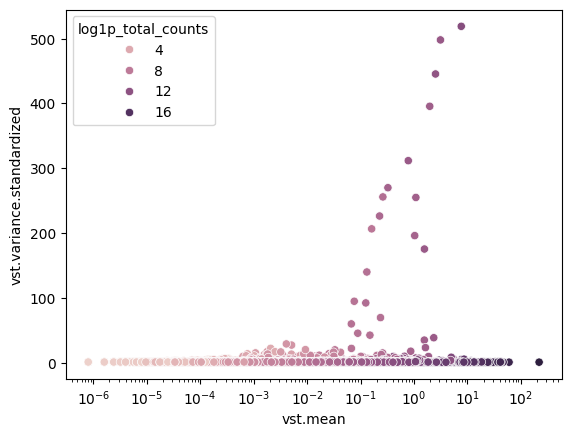

In [1168]:
sns.scatterplot(data=adata.var, x='vst.mean', y='vst.variance.standardized', hue='log1p_total_counts');
plt.xscale('log')

In [8]:
import os
import pandas as pd
grna_df = pd.read_parquet('../../metadata/sgrna_df_final.parquet')
# grna_df = pd.read_csv('../../metadata/sgRNA_library_curated.csv')
grna_df

sgRNA chromosome        pos         seq_last19bp strand    PAM  \
0        ARMC5-1      chr16   31459566  TGCCTCGCGCAGCTCGCGG      +   True   
1         DDB1-1      chr11   61333047  GAGTTCGCTGCGCGCTGTT      -   True   
2       FNDC10-1       chr1    1600078  GCCCGCTCCCCGCGATCCC      +   True   
3         RORC-1       chr1  151831746  CTGTGGGGCCCTGTCCATG      +   True   
4      SLC35F6-1       chr2   26764356  AACAGCTGGTACTTGGTCC      -   True   
...          ...        ...        ...                  ...    ...    ...   
25507    TYW1B-1       chr7   72744713  GCGTCGTGCAGATACTAGT      -   True   
25508   NBPF14-1       chr1  120451417  AATATTTATCAAACAGAGG      +   True   
25509    MUC12-2       chr7  100969567  TCTTGGTCCCTCCTGACGA      +  False   
25510   SRGAP2-2       chr1  206463364  CACAGGTCCCGAGCCAACG      +   True   
25511   NBPF11-2       chr1  148152266  GCCTGCAGTCCTAAACGCT      -   True   

                                                    note  flag  \
0      unique alignment, aligned to a cds but far fro...  True   
1      unique alignment, aligned to a cds but far fro...  True   
2      unique alignment, aligned to a cds but far fro...  True   
3      unique alignment, aligned to a cds but far fro...  True   
4      unique alignment, aligned to a cds but far fro...  True   
...                                                  ...   ...   
25507  hg17 alignment, AtoG at pos6, aligned to a cds...  True   
25508  hg17 alignment, AtoG at pos19, multi alignment...  True   
25509  unique alignment, target gene mismatch, aligne...  True   
25510  hg17 alignment, AtoG at pos11, within target g...  True   
25511  unique alignment, target gene mismatch, aligne...  True   

                        seq target_gene_name_from_sgRNA  ...  \
0      CTGCCTCGCGCAGCTCGCGG                       ARMC5  ...   
1      GGAGTTCGCTGCGCGCTGTT                        DDB1  ...   
2      TGCCCGCTCCCCGCGATCCC                      FNDC10  ...   
3      TCTGTGGGGCCCTGTCCATG                        RORC  ...   
4      GAACAGCTGGTACTTGGTCC                     SLC35F6  ...   
...                     ...                         ...  ...   
25507  GGCGTCGTGCAGATACTAGT                       TYW1B  ...   
25508  GAATATTTATCAAACAGAGG                      NBPF14  ...   
25509  GTCTTGGTCCCTCCTGACGA                       MUC12  ...   
25510  GCACAGGTCCCGAGCCAACG                      SRGAP2  ...   
25511  GGCCTGCAGTCCTAAACGCT                      NBPF11  ...   

      nearest_within2kb_gene_dist nearest_within2kb_nontarget_gene_id  \
0                            65.0                                None   
1                             6.0                     ENSG00000149476   
2                            57.0                                None   
3                            56.0                                None   
4                            66.0                     ENSG00000115163   
...                           ...                                 ...   
25507                         NaN                                None   
25508                         NaN                                None   
25509                         2.0                                None   
25510                         NaN                                None   
25511                        15.0                                None   

      nearest_within2kb_nontarget_gene_name  \
0                                      None   
1                                      TKFC   
2                                      None   
3                                      None   
4                                     CENPA   
...                                     ...   
25507                                  None   
25508                                  None   
25509                                  None   
25510                                  None   
25511                                  None   

      nearest_within2kb_nontarget_gene_dist putative_bidirectional_promoter  \
0  

In [14]:
grna_df[grna_df['sgRNA'] == 'NTC-001']

Empty DataFrame
Columns: [sgRNA, chromosome, pos, seq_last19bp, strand, PAM, note, flag, seq, target_gene_name_from_sgRNA, designed_target_gene_id, designed_target_gene_name, target_gene_id, target_gene_name, distance_to_closest_target_tss, nearby_gene_within_2kb, nearby_gene_within_30kb, nearest_within2kb_gene_id, nearest_within2kb_gene_name, nearest_within2kb_gene_dist, nearest_within2kb_nontarget_gene_id, nearest_within2kb_nontarget_gene_name, nearest_within2kb_nontarget_gene_dist, putative_bidirectional_promoter, other_alignment_chromosome, other_alignment_pos, nearest_nontarget_gene_id, nearest_nontarget_gene_name, nearest_nontarget_gene_dist]
Index: []

[0 rows x 29 columns]